# final_analysis.py.ipynb
This notebook plots the figures for the manuscript. It starts with a single source of input data (`integrate_data.csv`). We restrict the analysis to our sample of interest (cells infected by a WT virus). Then, we calculate the necessary outcome metrics and plot the outcomes of infection.

## Notebook setup
Import Python modules:

In [1]:
from IPython.display import display
from pymodules.gini import *
from scipy import stats
from svgutils.compose import *
import altair as alt
import altair_saver
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotnine as p9
import random
import scikit_posthocs as sp
import seaborn as sns
import subprocess

Set the theme for plots:

In [2]:
p9.theme_set(p9.theme_classic())
CBPALETTE = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
title_size = 14
axis_label_size = 12
axis_text_size = 12
facet_label_size = 10
fig_letter_size = 18
def sample_labeller(name):
    if name == "lowMOI":
        return "Low MOI"
    elif name == "highMOI":
        return "High MOI"
    else:
        return name

Set output folder for figures:

In [3]:
figure_dir = 'results/figures'
if not os.path.exists(figure_dir):
    # Create a new directory because it does not exist 
    os.makedirs(figure_dir)
    print(f"Made `{figure_dir}` directory ")
else:
    print(f"Directory `{figure_dir}` already exists.")

Directory `results/figures` already exists.


## Input data
### Read input data
The general structure of the `integrated_data_csv` file is that each cell barcode is listed on a row, and features of that cell are listed in columns. Cells that have more than one valid viral barcode identified may have multiple rows--one for each valid viral barcode.

In [4]:
all_samples_csv = 'results/viral_fastq10x/all_samples.csv'
integrated_data = pd.read_csv(all_samples_csv)
integrated_data

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,n_viral_genes,transcriptome_UMIs_fluHA,transcriptome_UMIs_fluM,transcriptome_UMIs_fluNA,...,pacbio_UMIs_fluPB1,pacbio_UMIs_fluPB2,mutation_support_fluHA,mutation_support_fluM,mutation_support_fluNA,mutation_support_fluNP,mutation_support_fluNS,mutation_support_fluPA,mutation_support_fluPB1,mutation_support_fluPB2
0,AAACGAAAGCCACCGT,ambiguous,wt,41743,451,0.010804,6,101,54,26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAACGCTAGTTCACTG,infected,syn,11572,4702,0.406326,7,650,2075,101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAACGCTAGTTCACTG,infected,syn,11572,4702,0.406326,7,650,2075,101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAACGCTAGTTCACTG,infected,syn,11572,4702,0.406326,7,650,2075,101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAACGCTAGTTCACTG,infected,syn,11572,4702,0.406326,7,650,2075,101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6339,TTTGATCTCCCGTTCA,uninfected,none,63150,3,0.000048,0,0,1,0,...,0.0,0.0,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable
6340,TTTGGAGAGTTGCCTA,uninfected,none,65941,12,0.000182,0,0,6,1,...,0.0,0.0,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable
6341,TTTGGAGGTATCGTTG,infected,wt,150130,3526,0.023486,8,93,1668,45,...,23.0,7.0,Not Applicable,Not Applicable,31/31,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable
6342,TTTGGAGGTATCGTTG,infected,wt,150130,3526,0.023486,8,93,1668,45,...,23.0,7.0,Not Applicable,Not Applicable,31/31,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable


### Combine data for each cell into single row
Process the dataframe so that each cell becomes a single row. Progeny contributions are summed for each cell, source, and barcoded gene (e.g. supernatant_freq_fluHA) and listed in a column.

In [5]:
min_viral_barcode_freq = 1e-5  # value assigned to unobserved viral barcodes

# aggregate observed viral barcodes for each gene and cell
processed_data = (
    integrated_data
    .groupby(["sample", "cell_barcode", "barcoded_gene"], as_index=False)
    .aggregate(
        n_viral_barcodes=pd.NamedAgg("viral_barcode", lambda v: v.astype(bool).astype(int).sum()),
        viral_barcodes=pd.NamedAgg("viral_barcode", "; ".join),
        freq_supernatant=pd.NamedAgg("freq_supernatant", "sum"),
        freq_second_infection=pd.NamedAgg("freq_second_infection", "sum"),
    )
)
assert processed_data.notnull().all().all()

# get barcoded viral genes
barcoded_genes = processed_data["barcoded_gene"].unique().tolist()

# now pivot so just one row per cell
pivoted_dfs = []
for col_to_pivot, fill_value in [
    ("n_viral_barcodes", 0),
    ("viral_barcodes", ""),
    ("freq_supernatant", pd.NA),
    ("freq_second_infection", pd.NA),
]:
    pivoted_dfs.append(
        processed_data
        .pivot_table(
            index=["sample", "cell_barcode"],
            columns="barcoded_gene",
            values=col_to_pivot,
            fill_value=fill_value,
            aggfunc='sum',
        )
        .rename_axis(None, axis=1)
        .rename(columns={gene: f"{col_to_pivot}_{gene}" for gene in barcoded_genes})
    )
assert all((pivoted_dfs[0].index == df.index).all() for df in pivoted_dfs)
processed_data = pd.concat(pivoted_dfs, axis=1).reset_index()

# now add back in cell-specific information
# Require infected cells since the above measurements only make sense for
# infected cells.
cell_info = (
    integrated_data
    [['sample', 'cell_barcode', 'infected', 'infecting_viral_tag',
      'total_UMIs', 'viral_UMIs', 'frac_viral_UMIs', 'n_viral_genes'] +
     [c for c in integrated_data.columns
      if re.match("transcriptome_UMIs_flu|frac_UMIs_flu|present_flu|pacbio_UMIs|mutations_|mutation_support_", c)]
    ]
    .drop_duplicates()
)

assert set(processed_data[["sample", "cell_barcode"]]).issubset(cell_info[["sample", "cell_barcode"]])
processed_data = (
    cell_info.query('infected == "infected"')
    .merge(processed_data, on=["sample", "cell_barcode"], how="left", validate="one_to_one")
)

# add columns explaining missing genes
present_columns = {c: c.replace("present_flu", "") for c in processed_data.columns
                   if re.match("present_flu", c)}

processed_data = (
    processed_data
    .assign(
        all_viral_genes=lambda x: x['n_viral_genes'] == len(present_columns),
        missing_viral_genes=lambda x: x.apply(lambda row:
            "; ".join(val for (key, val) in present_columns.items() if not row[key]),
            axis=1)
    )
)

# fill missing pacbio UMI counts with 0s
processed_data[[c for c in processed_data.columns if re.match("pacbio_UMIs", c)]] = \
processed_data[[c for c in processed_data.columns if re.match("pacbio_UMIs", c)]].fillna(0)

# check for complete pacbio data for all expressed viral genes
def virus_fully_sequenced(row):
    row_dict = row.to_dict()
    for key, val in row_dict.items():
        if re.fullmatch("present_flu\w+", key) and val:
            gene = key.split("_")[1]
            if row_dict[f"pacbio_UMIs_{gene}"] < 2:
                return False
    else:
        return True

processed_data = (
    processed_data
    .assign(virus_fully_sequenced=lambda x: x.apply(virus_fully_sequenced, axis=1))
)

# check to see if cell expresses both barcoded viral genes
processed_data["all_barcoded_genes"] = np.logical_and.reduce(
    [processed_data[f"present_{gene}"] for gene in barcoded_genes] +
    [processed_data[f"freq_supernatant_{gene}"].notnull() for gene in barcoded_genes] +
    [processed_data[f"freq_second_infection_{gene}"].notnull() for gene in barcoded_genes]
)

# annotate cells with both complete pacbio data and both barcoded viral genes
def sequenced_and_barcoded(row):
    if row['virus_fully_sequenced'] and row['all_barcoded_genes']:
        return "sequenced and barcoded"
    elif row['virus_fully_sequenced']:
        return "sequenced"
    elif row['all_barcoded_genes']:
        return "barcoded"
    else:
        return "not sequenced or barcoded"
processed_data["sequenced_and_barcoded"] = (
    processed_data.apply(sequenced_and_barcoded, axis=1)
)

display(processed_data)

,sample,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,n_viral_genes,transcriptome_UMIs_fluHA,transcriptome_UMIs_fluM,...,viral_barcodes_fluNA,freq_supernatant_fluHA,freq_supernatant_fluNA,freq_second_infection_fluHA,freq_second_infection_fluNA,all_viral_genes,missing_viral_genes,virus_fully_sequenced,all_barcoded_genes,sequenced_and_barcoded
0,highMOI,AAACGCTAGTTCACTG,infected,syn,11572,4702,0.406326,7,650,2075,...,AAATTCTTGGGGCGAC; TGATAGCGTAGACGTT; ATGAATTATA...,0.001942,0.002176,0.002218,0.001432,False,PA,False,True,barcoded
1,highMOI,AAAGAACGTAATTGGA,infected,syn,24525,3948,0.160979,7,456,1340,...,,0.000077,<NA>,0.000416,<NA>,False,NA,False,False,not sequenced or barcoded
2,highMOI,AAAGGATCATTGCAAC,infected,wt,17304,888,0.051318,6,160,144,...,,0.000013,<NA>,0.000064,<NA>,False,NA; NP,False,False,not sequenced or barcoded
3,highMOI,AAAGGGCGTGTATTCG,infected,both,12578,6213,0.493958,8,390,3719,...,NaN,NaN,NaN,NaN,NaN,True,,False,False,not sequenced or barcoded
4,highMOI,AAAGGGCGTTGCCTAA,infected,wt,36880,6704,0.181779,6,1079,6,...,,0.00001,<NA>,0.00001,<NA>,False,M; NA,False,False,not sequenced or barcoded
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912,lowMOI,TTGGGATGTAACGATA,infected,wt,161690,9470,0.058569,8,407,4600,...,TAAAAAATGTCTCATG,0.001014,0.001284,0.000154,0.000015,True,,True,True,sequenced and barcoded
913,lowMOI,TTGGGATTCCGATTAG,infected,syn,137623,6652,0.048335,8,262,3656,...,GTTTCGTGAGCATGTA,0.00001,0.00001,0.00001,0.00001,True,,True,True,sequenced and barcoded
914,lowMOI,TTTACCAGTCGCTTAA,infected,wt,114567,1434,0.012517,7,125,609,...,ATTTGGATGTAGGGGC; TTGGAGGAGACCCGTG,0.000106,0.001222,0.00002,0.000029,False,PA,False,True,barcoded
915,lowMOI,TTTCACAAGCCAAGCA,infected,wt,68424,2308,0.033731,6,475,796,...,GGTATCAGTTATTGTT,0.00001,0.00001,0.00001,0.00001,False,NS; PB1,True,True,sequenced and barcoded


**Order samples**

In [6]:
processed_data['sample'] = (
    processed_data['sample']
    .astype('category')
    .cat
    .reorder_categories(['lowMOI', 'highMOI'])
)
processed_data['sample']

0      highMOI
1      highMOI
2      highMOI
3      highMOI
4      highMOI
        ...   
912     lowMOI
913     lowMOI
914     lowMOI
915     lowMOI
916     lowMOI
Name: sample, Length: 917, dtype: category
Categories (2, object): ['lowMOI', 'highMOI']

### Restrict analysis to WT infected cells
We only want to plot our sample of interest, which is made up of cells infected by a WT virus. We will exclude uninfected cells, infected multiplets (transcriptomes derived from both WT and dblSyn cells), and infected dblSyn cells.

In [7]:
wt_infected_cells = (
    processed_data
    .query('infected == "infected" and infecting_viral_tag == "wt"'))
wt_infected_cells

,sample,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,n_viral_genes,transcriptome_UMIs_fluHA,transcriptome_UMIs_fluM,...,viral_barcodes_fluNA,freq_supernatant_fluHA,freq_supernatant_fluNA,freq_second_infection_fluHA,freq_second_infection_fluNA,all_viral_genes,missing_viral_genes,virus_fully_sequenced,all_barcoded_genes,sequenced_and_barcoded
2,highMOI,AAAGGATCATTGCAAC,infected,wt,17304,888,0.051318,6,160,144,...,,0.000013,<NA>,0.000064,<NA>,False,NA; NP,False,False,not sequenced or barcoded
4,highMOI,AAAGGGCGTTGCCTAA,infected,wt,36880,6704,0.181779,6,1079,6,...,,0.00001,<NA>,0.00001,<NA>,False,M; NA,False,False,not sequenced or barcoded
8,highMOI,AACAACCGTGATTCTG,infected,wt,54425,2669,0.049040,8,240,1364,...,TCCTAAGTTAGTACCT,0.00002,0.002127,0.000058,0.032429,True,,False,True,barcoded
9,highMOI,AACAAGAAGAGCCGTA,infected,wt,24519,6007,0.244994,3,3,3,...,NaN,NaN,NaN,NaN,NaN,False,HA; M; NA; NS; PA,False,False,not sequenced or barcoded
10,highMOI,AACCACATCTTCCACG,infected,wt,32831,2822,0.085955,8,267,985,...,TATATAAATCAGTGGA,0.000047,0.00001,0.000125,0.000182,True,,False,True,barcoded
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
911,lowMOI,TTGCGTCCACCCTCTA,infected,wt,160497,1816,0.011315,7,241,678,...,GAGCTCCTGTATTGCC,0.00001,0.00001,0.00001,0.00001,False,PA,True,True,sequenced and barcoded
912,lowMOI,TTGGGATGTAACGATA,infected,wt,161690,9470,0.058569,8,407,4600,...,TAAAAAATGTCTCATG,0.001014,0.001284,0.000154,0.000015,True,,True,True,sequenced and barcoded
914,lowMOI,TTTACCAGTCGCTTAA,infected,wt,114567,1434,0.012517,7,125,609,...,ATTTGGATGTAGGGGC; TTGGAGGAGACCCGTG,0.000106,0.001222,0.00002,0.000029,False,PA,False,True,barcoded
915,lowMOI,TTTCACAAGCCAAGCA,infected,wt,68424,2308,0.033731,6,475,796,...,GGTATCAGTTATTGTT,0.00001,0.00001,0.00001,0.00001,False,NS; PB1,True,True,sequenced and barcoded


In [8]:
for sample in wt_infected_cells['sample'].unique():
    n_wt_infected_cells = wt_infected_cells.query(f'sample == "{sample}"')["cell_barcode"].nunique()
    print(f'There are {n_wt_infected_cells} WT infected cells in the {sample} dataset.')

There are 357 WT infected cells in the highMOI dataset.
There are 254 WT infected cells in the lowMOI dataset.


## General transcriptional outcomes of infection
### Plot viral transcription
I will plot the histogram of viral transcription. I need to know where to set the limits and bins, so I will look up the maximum viral transcription fraction for these data.

In [9]:
print(f'The maximum fraction of viral transcription '
      f'in an infected cells is {wt_infected_cells["frac_viral_UMIs"].max()}')

The maximum fraction of viral transcription in an infected cells is 0.8403226839106217


/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 8.5 x 4 in image.
/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: results/figures/viral_transcription.svg


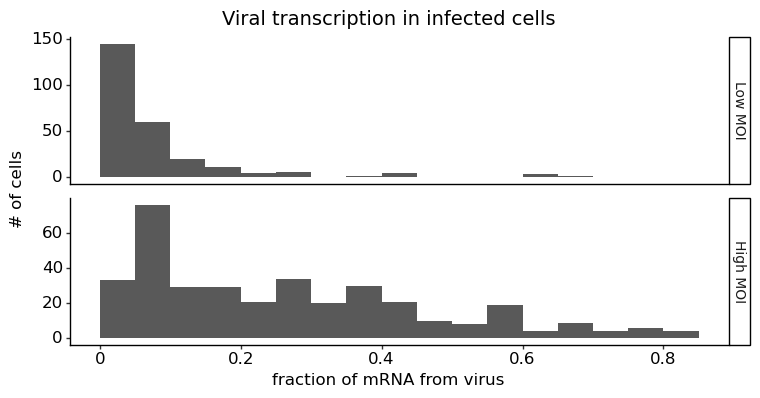

<ggplot: (8787467167196)>

In [10]:
viral_transcription_file = figure_dir+'/'+'viral_transcription.svg'

viral_transcription_plot = (
    p9.ggplot(
        wt_infected_cells,
        p9.aes(x='frac_viral_UMIs')) +
    p9.geom_histogram(breaks=[0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,
                              0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85]) +
    p9.facet_grid('sample~',
                  labeller=p9.labeller(sample_labeller),
                  scales='free_y') +
    p9.ggtitle(f'Viral transcription in infected cells') +
    p9.labs(x='fraction of mRNA from virus',
            y='# of cells') +
    p9.theme(figure_size=(8.5, 4),
             plot_title=p9.element_text(size=title_size),
             axis_title=p9.element_text(size=axis_label_size),
             axis_text=p9.element_text(size=axis_text_size, color="black"),
             strip_text=p9.element_text(size=facet_label_size),
             subplots_adjust={'hspace':0.1}))
viral_transcription_plot.save(filename = viral_transcription_file)
display(viral_transcription_plot)

### Plot viral genes per infected cell

/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 2.5 x 3 in image.
/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: results/figures/genes_per_cell.svg


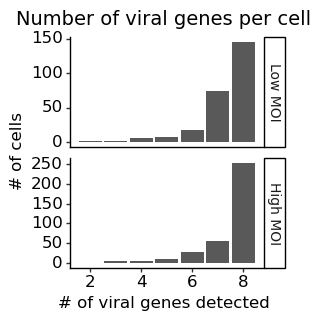

<ggplot: (8787466985707)>

In [11]:
genes_per_cell_file = figure_dir+'/'+'genes_per_cell.svg'

genes_per_cell_plot = (
    p9.ggplot(
        wt_infected_cells[['sample', 'cell_barcode', 'n_viral_genes']].drop_duplicates(),
        p9.aes(x='n_viral_genes')) +
    p9.geom_bar(stat='count', position='dodge') +
    p9.facet_grid('sample~',
                  labeller=p9.labeller(sample_labeller),
                  scales='free_y') +
    p9.ggtitle('Number of viral genes per cell') +
    p9.labs(x='# of viral genes detected',
            y='# of cells') +
    p9.theme(figure_size=(2.5, 3),
                plot_title=p9.element_text(size=title_size),
                axis_title=p9.element_text(size=axis_label_size),
                axis_text=p9.element_text(size=axis_text_size, color="black"),
                strip_text=p9.element_text(size=facet_label_size),
                subplots_adjust={'hspace':0.1}))
genes_per_cell_plot.save(filename = genes_per_cell_file)
display(genes_per_cell_plot)

### Plot viral gene presence or absence

To generate this plot, I need to tabulate how many cells express or do not express each viral gene. I will make a new dataframe with cell barcode, frac_viral_UMIs, and gene as columns. For each cell, I will list whether the gene is present and the fraction of gene UMIs in the cell.

In [12]:
gene_present_by_cell = (
    wt_infected_cells
    [['sample', 'cell_barcode',
      'present_fluPB2', 'present_fluPB1',
      'present_fluPA', 'present_fluHA',
      'present_fluNP', 'present_fluNA',
      'present_fluM', 'present_fluNS']]
    .drop_duplicates()
    .melt(
        id_vars=['sample', 'cell_barcode'],
        var_name='gene',
        value_name='gene_present')
)
gene_present_by_cell['gene'] = (
    gene_present_by_cell['gene']
    .str.split('_').str[-1])

gene_frac_by_cell = (
    wt_infected_cells
    [['sample', 'cell_barcode', 'frac_viral_UMIs',
      'frac_UMIs_fluPB2', 'frac_UMIs_fluPB1',
      'frac_UMIs_fluPA', 'frac_UMIs_fluHA',
      'frac_UMIs_fluNP', 'frac_UMIs_fluNA',
      'frac_UMIs_fluM', 'frac_UMIs_fluNS']]
    .drop_duplicates()
    .melt(
        id_vars=['sample', 'cell_barcode', 'frac_viral_UMIs'],
        var_name='gene',
        value_name='frac_gene_UMIs')
)
gene_frac_by_cell['gene'] = (
    gene_frac_by_cell['gene']
    .str.split('_').str[-1])

viral_genes_by_cell = pd.merge(
    left=gene_present_by_cell,
    right=gene_frac_by_cell,
    on=['sample', 'cell_barcode','gene'],
    how='outer'
)
viral_genes_by_cell['gene'] = (
    viral_genes_by_cell['gene']
    .replace(['fluPB2', 'fluPB1', 'fluPA', 'fluHA',
              'fluNP', 'fluNA', 'fluM', 'fluNS'],
             ['PB2', 'PB1', 'PA', 'HA',
              'NP', 'NA', 'M', 'NS']))
viral_genes_by_cell['gene'] = (
    viral_genes_by_cell['gene'].astype('category'))
viral_genes_by_cell['gene'] = (
    viral_genes_by_cell['gene']
    .cat.reorder_categories(
        ['PB2', 'PB1', 'PA', 'HA',
         'NP', 'NA', 'M', 'NS']))
viral_genes_by_cell['gene_present'] = (
    viral_genes_by_cell['gene_present']
    .replace([True,False],
             ["Gene present", "Gene absent"]))

for sample in wt_infected_cells['sample'].unique():
    assert viral_genes_by_cell.query(f'sample == "{sample}"')['cell_barcode'].unique().all() == \
           wt_infected_cells.query(f'sample == "{sample}"')['cell_barcode'].unique().all(), \
           f"Cell barcodes don't match for {sample}"

display(viral_genes_by_cell)

gene_absence_rate = pd.DataFrame(
    viral_genes_by_cell
    .groupby(['sample', 'gene'])
    ['gene_present']
    .value_counts(normalize=True)
    .reset_index(name='fraction_cells'))


assert(gene_absence_rate['gene'].nunique() == 8)

display(gene_absence_rate)

,sample,cell_barcode,gene,gene_present,frac_viral_UMIs,frac_gene_UMIs
0,highMOI,AAAGGATCATTGCAAC,PB2,Gene present,0.051318,0.000347
1,highMOI,AAAGGGCGTTGCCTAA,PB2,Gene present,0.181779,0.002359
2,highMOI,AACAACCGTGATTCTG,PB2,Gene present,0.049040,0.000220
3,highMOI,AACAAGAAGAGCCGTA,PB2,Gene present,0.244994,0.025083
4,highMOI,AACCACATCTTCCACG,PB2,Gene present,0.085955,0.000183
...,...,...,...,...,...,...
4883,lowMOI,TTGCGTCCACCCTCTA,NS,Gene present,0.011315,0.002885
4884,lowMOI,TTGGGATGTAACGATA,NS,Gene present,0.058569,0.022673
4885,lowMOI,TTTACCAGTCGCTTAA,NS,Gene present,0.012517,0.004836
4886,lowMOI,TTTCACAAGCCAAGCA,NS,Gene absent,0.033731,0.000015


,sample,gene,gene_present,fraction_cells
0,lowMOI,PB2,Gene present,0.933071
1,lowMOI,PB2,Gene absent,0.066929
2,lowMOI,PB1,Gene present,0.960630
3,lowMOI,PB1,Gene absent,0.039370
4,lowMOI,PA,Gene present,0.913386
5,lowMOI,PA,Gene absent,0.086614
6,lowMOI,HA,Gene present,0.854331
7,lowMOI,HA,Gene absent,0.145669
8,lowMOI,NP,Gene present,0.960630
9,lowMOI,NP,Gene absent,0.039370


Plot the fraction of infected cells missing each viral gene.

/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 4 x 3 in image.
/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: results/figures/gene_absence_plot.svg


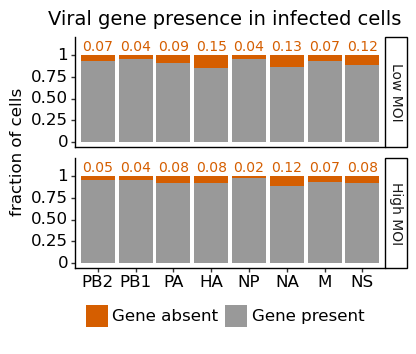

<ggplot: (8787467192342)>

In [13]:
gene_absence_file = figure_dir+'/'+'gene_absence_plot.svg'

gene_absence_plot = (
    p9.ggplot(gene_absence_rate,
              p9.aes(x='gene',
                     y='fraction_cells',
                     fill='gene_present')) +
    p9.geom_bar(stat='identity') +
    p9.geom_text(data=gene_absence_rate.query('gene_present == "Gene absent"'),
           mapping=p9.aes(x='gene',
                          y=1.1,
                          label='fraction_cells'),
                          format_string='{:.2f}',
                          size=10,
                          color=CBPALETTE[6]) +
    p9.facet_grid('sample~', labeller=p9.labeller(sample_labeller)) +
    p9.ggtitle('Viral gene presence in infected cells') +
    p9.labs(x = '', y='fraction of cells') +
    p9.scale_y_continuous(limits=[0,1.15],
                          breaks=[0,0.25,0.5,0.75,1])+
    p9.theme(figure_size=(4, 3),
             plot_title=p9.element_text(size=title_size),
             axis_title=p9.element_text(size=axis_label_size),
             axis_text=p9.element_text(size=axis_text_size, color="black"),
             strip_text=p9.element_text(size=facet_label_size),
             subplots_adjust={'hspace':0.1},
             legend_position='bottom',
             legend_box_spacing=0.2,
             legend_title=p9.element_blank(),
             legend_text=p9.element_text(size=12)) +
    p9.scale_fill_manual([CBPALETTE[6],CBPALETTE[0]]))

gene_absence_plot.save(filename = gene_absence_file)
display(gene_absence_plot)

### Make composite Fig 2
Make a composite figure showing viral transcription, number of viral genes per cell, and rate of viral gene absence.

**N.b. For some reason this cell and the ones immediatebly above need to be run manually to generate a correct figure. When run automatically, panel A is undersized.**

In [14]:
fig2_file = figure_dir+'/'+'fig2.svg'

fig2 = (Figure("15cm", "15cm",
       Panel(
#           Grid(20, 20),
           SVG(viral_transcription_file).move(10,0),
           Text("A", 5, 15, size=fig_letter_size)),
       Panel(
           SVG(genes_per_cell_file).move(20,0),
           Text("B", 5, 15, size=fig_letter_size)).move(0,300),
       Panel(
           SVG(gene_absence_file),
           Text("C", 5, 15, size=fig_letter_size)).move(260,300),
       ))
display(fig2)
fig2.save(fig2_file)

### Plot viral gene presence or absence raw data
For each single infected cell, plot the expression of each viral gene relative to total viral expression. Color by whether gene was called as present or absent.

/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 12 x 3 in image.
/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: results/figures/gene_expression_plot.svg
/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10


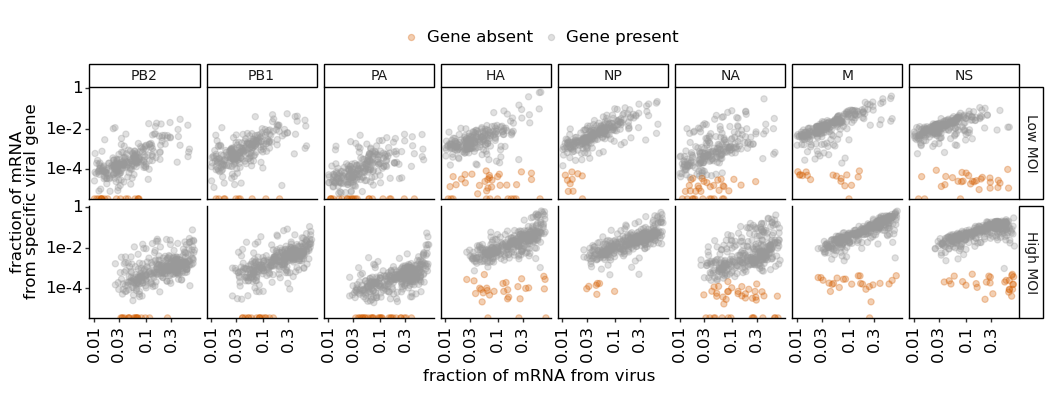

<ggplot: (8787466649221)>

In [15]:
gene_expression_file = figure_dir+'/'+'gene_expression_plot.svg'

gene_expression_plot = (
    p9.ggplot(viral_genes_by_cell,
               p9.aes(x='frac_viral_UMIs',
                      y='frac_gene_UMIs',
                      color='gene_present')) +
    p9.geom_point(alpha=0.3, size=2) +
    p9.facet_grid('sample~gene', labeller=p9.labeller(sample_labeller)) +
    p9.labs(x='fraction of mRNA from virus',
            y='fraction of mRNA\nfrom specific viral gene') +
    p9.scale_x_log10(breaks=[0.01,0.03,0.1,0.3]) +
    p9.scale_y_log10(breaks=[1e-4,1e-2,1]) +
    p9.theme(figure_size=(12, 3),
             plot_title=p9.element_text(size=title_size),
             axis_title=p9.element_text(size=axis_label_size),
             axis_text=p9.element_text(size=axis_text_size, color="black"),
             strip_text=p9.element_text(size=facet_label_size),
             axis_text_x=p9.element_text(rotation=90),
             legend_position='top',
             legend_box_spacing=0,
             legend_title=p9.element_blank(),
             legend_text=p9.element_text(size=12)) +
    p9.scale_color_manual([CBPALETTE[6],CBPALETTE[0]]))

gene_expression_plot.save(filename = gene_expression_file)
display(gene_expression_plot)

## Viral genome sequencing
**Note: all of this analysis is restricted to trial3, which has pacbio sequencing data.**
### Plot viral transcription in fully-sequenced cells
For later analyses, I will require the cells to have PacBio sequencing information for all expressed viral genes, so that we can call consensus genomes. I want to see how viral transcription activity is associated with our ability to fully sequence a viral genome.


/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 3.5 x 1.75 in image.
/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: results/figures/fully_sequenced_plot.svg


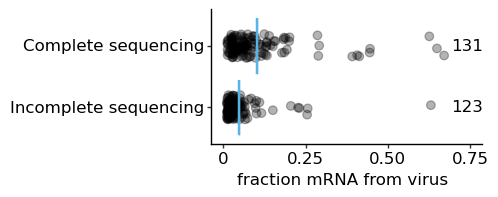

<ggplot: (8787451303638)>

In [16]:
fully_sequenced_file = figure_dir+'/'+'fully_sequenced_plot.svg'

fully_sequenced_plot = (
    p9.ggplot(wt_infected_cells.query('sample == "lowMOI"'),
               p9.aes(x='virus_fully_sequenced',
                      y='frac_viral_UMIs')) +
    p9.geom_jitter(alpha=0.3, size=3, width=0.2) +
    p9.stat_summary(fun_y=np.mean, 
                    fun_ymin=np.mean,
                    fun_ymax=np.mean,
                    geom='crossbar',
                    width=0.9,
                    color=CBPALETTE[2]) +
    p9.geom_text(data=wt_infected_cells.query('sample == "lowMOI"').groupby('virus_fully_sequenced').nunique().reset_index(),
                 mapping=p9.aes(y=0.74,
                                label='cell_barcode'),
                 size=12) +
    p9.coord_flip() +
    p9.labs(x='',
            y='fraction mRNA from virus') +
    p9.scale_y_continuous(limits=[0,0.75], breaks=[0,0.25,0.5,0.75]) +
    p9.scale_x_discrete(labels=['Incomplete sequencing', 'Complete sequencing']) +
    p9.theme(figure_size=(3.5, 1.75),
             plot_title=p9.element_text(size=title_size),
             axis_title=p9.element_text(size=axis_label_size),
             axis_text=p9.element_text(size=axis_text_size, color="black"),
             strip_text=p9.element_text(size=facet_label_size)))

fully_sequenced_plot.save(filename = fully_sequenced_file)
display(fully_sequenced_plot)

Now, generate a dataframe that is a subset of `wt_infected_cells`, containing just cells with complete PacBio sequencing of all expressed viral genes.

In [17]:
fully_sequenced_cells = (
    wt_infected_cells
    .query('sample == "lowMOI" and virus_fully_sequenced == True'))
display(fully_sequenced_cells)

,sample,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,n_viral_genes,transcriptome_UMIs_fluHA,transcriptome_UMIs_fluM,...,viral_barcodes_fluNA,freq_supernatant_fluHA,freq_supernatant_fluNA,freq_second_infection_fluHA,freq_second_infection_fluNA,all_viral_genes,missing_viral_genes,virus_fully_sequenced,all_barcoded_genes,sequenced_and_barcoded
510,lowMOI,AAAGGGCTCCGCACTT,infected,wt,128527,3021,0.023505,7,86,735,...,CTCGTTTTCGGAGTAC; GACTATCTAATTGAGG,0.003532,0.000135,0.000165,0.00002,False,PA,True,True,sequenced and barcoded
511,lowMOI,AAAGTCCAGTAGAGTT,infected,wt,75830,15135,0.199591,8,566,7232,...,TTTACTTTAAGTGCTT,0.00001,0.00001,0.00001,0.00001,True,,True,True,sequenced and barcoded
512,lowMOI,AACCAACAGGGTCTTT,infected,wt,130332,17157,0.131641,8,1347,6280,...,AGTTATTGGTTGGATA,0.00002,0.000971,0.00002,0.000022,True,,True,True,sequenced and barcoded
517,lowMOI,AAGGAATAGATTGAGT,infected,wt,51455,1667,0.032397,6,3,435,...,TCGGTGGATAACCTTG,<NA>,0.00001,<NA>,0.00001,False,HA; PB2,True,False,sequenced
518,lowMOI,AAGGAATAGCATCGAG,infected,wt,91039,3192,0.035062,8,114,1262,...,CTGTTGTTCTTTACCA,0.00001,0.000072,0.000202,0.000165,True,,True,True,sequenced and barcoded
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
910,lowMOI,TTGAGTGTCCTGGGTG,infected,wt,43013,8648,0.201055,8,795,2317,...,GTATTTGCAAAAAATG,0.00013,0.000904,0.00001,0.000014,True,,True,True,sequenced and barcoded
911,lowMOI,TTGCGTCCACCCTCTA,infected,wt,160497,1816,0.011315,7,241,678,...,GAGCTCCTGTATTGCC,0.00001,0.00001,0.00001,0.00001,False,PA,True,True,sequenced and barcoded
912,lowMOI,TTGGGATGTAACGATA,infected,wt,161690,9470,0.058569,8,407,4600,...,TAAAAAATGTCTCATG,0.001014,0.001284,0.000154,0.000015,True,,True,True,sequenced and barcoded
915,lowMOI,TTTCACAAGCCAAGCA,infected,wt,68424,2308,0.033731,6,475,796,...,GGTATCAGTTATTGTT,0.00001,0.00001,0.00001,0.00001,False,NS; PB1,True,True,sequenced and barcoded


### Aggregate mutation information
Viral mutation information from the PacBio sequencing is currently spread across many columns (one for each gene). I want to aggregate all viral mutaiton information into a single column so that I can display this on plots in the future. I will also annotate cells by whether they have non-synonymous mutations.

In [18]:
def viral_mutations(row):
    row_dict = row.to_dict()
    mutations = []
    for key, val in row_dict.items():
        if re.fullmatch("mutations_flu\w+", key) and val:
            gene = key.replace("mutations_flu", "")
            if val == "Not Detected":
                assert not row_dict[f"present_flu{gene}"]
            elif val != "WT":
                mutations.append(f"{gene}: {val}")
    return ", ".join(mutations)

def nonsynonymous_mutations(row):
    row_dict = row.to_dict()
    nonsynonymous_mutations = []
    for key, val in row_dict.items():
        if re.fullmatch("mutations_flu\w+", key) and val:
            gene = key.replace("mutations_flu", "")
            if val == "Not Detected":
                assert not row_dict[f"present_flu{gene}"]
            elif val != "WT":
                for x in val.split(' '):
                    if "synonymous" in x:
                        pass
                    elif "noncoding" in x:
                        pass
                    else:
                        nonsynonymous_mutations.append(f"{gene}: {x}")
    return ", ".join(nonsynonymous_mutations)

def nonsynonymous_mutation_count(row):
    row_dict = row.to_dict()
    nonsynonymous_mutation_count = 0
    for key, val in row_dict.items():
        if re.fullmatch("mutations_flu\w+", key) and val:
            gene = key.replace("mutations_flu", "")
            if val == "Not Detected":
                assert not row_dict[f"present_flu{gene}"]
            elif val != "WT":
                for x in val.split(' '):
                    if "synonymous" in x:
                        pass
                    elif "noncoding" in x:
                        pass
                    else:
                        nonsynonymous_mutation_count += 1
    return nonsynonymous_mutation_count

def mutation_support(row):
    row_dict = row.to_dict()
    support_vals = []
    for key, val in row_dict.items():
        if re.fullmatch("mutation_support_flu\w+", key) and val:
            gene = key.replace("mutation_support_flu", "")
            if val != "Not Applicable":
                support_vals.append(f"{gene}: {val}")
    return ", ".join(support_vals)

def mutated_genes(row):
    row_dict = row.to_dict()
    mutated_genes = []
    for key, val in row_dict.items():
        if re.fullmatch("mutations_flu\w+", key) and val:
            gene = key.replace("mutations_flu", "")
            if val == "Not Detected":
                assert not row_dict[f"present_flu{gene}"]
            elif val != "WT":
                mutated_genes.append(gene)
    return ", ".join(mutated_genes)

def label_cells(row):
    cell_label = None
    if row['all_viral_genes'] == True:
        if row['has_nonsynonymous_mutations'] == False:
            cell_label = "Complete unmutated genome"
        else:
            cell_label = "Complete mutated genome"
    elif row['all_viral_genes'] == False:
        if row['has_nonsynonymous_mutations'] == False:
            cell_label = "Missing viral gene(s)"
        else:
            cell_label = "Missing viral gene(s) and\nnon-synonymous mutations"
    return cell_label

fully_sequenced_cells = (
    fully_sequenced_cells
    .assign(
        viral_mutations=lambda x: x.apply(viral_mutations, axis=1),
        nonsynonymous_mutations=lambda x: x.apply(nonsynonymous_mutations, axis=1),
        mutation_support=lambda x: x.apply(mutation_support, axis=1),
        mutated_genes=lambda x: x.apply(mutated_genes, axis=1),
        has_mutations=lambda x: x["mutated_genes"].astype(bool),
        has_nonsynonymous_mutations=lambda x: x["nonsynonymous_mutations"].astype(bool),
        nonsynonymous_mutation_count=lambda x: x.apply(nonsynonymous_mutation_count, axis=1),
        cell_label=lambda x: x.apply(label_cells, axis=1).astype('category')
    )
)
display(fully_sequenced_cells)

,sample,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,n_viral_genes,transcriptome_UMIs_fluHA,transcriptome_UMIs_fluM,...,all_barcoded_genes,sequenced_and_barcoded,viral_mutations,nonsynonymous_mutations,mutation_support,mutated_genes,has_mutations,has_nonsynonymous_mutations,nonsynonymous_mutation_count,cell_label
510,lowMOI,AAAGGGCTCCGCACTT,infected,wt,128527,3021,0.023505,7,86,735,...,True,sequenced and barcoded,PB2: del168to2007 del2097to2106,"PB2: del168to2007, PB2: del2097to2106",PB2: 1597/1611 1601/1611,PB2,True,True,2,Missing viral gene(s) and\nnon-synonymous muta...
511,lowMOI,AAAGTCCAGTAGAGTT,infected,wt,75830,15135,0.199591,8,566,7232,...,True,sequenced and barcoded,,,,,False,False,0,Complete unmutated genome
512,lowMOI,AACCAACAGGGTCTTT,infected,wt,130332,17157,0.131641,8,1347,6280,...,True,sequenced and barcoded,"M: A111C_synonymous, NA: del39to1256, NS: G550...","NA: del39to1256, NS: G550A_G184R, PA: A937C_T313P","M: 436/472, NA: 1483/1550, NS: 48/50, PA: 7/9","M, NA, NS, PA",True,True,3,Complete mutated genome
517,lowMOI,AAGGAATAGATTGAGT,infected,wt,51455,1667,0.032397,6,3,435,...,False,sequenced,,,,,False,False,0,Missing viral gene(s)
518,lowMOI,AAGGAATAGCATCGAG,infected,wt,91039,3192,0.035062,8,114,1262,...,True,sequenced and barcoded,"NA: del43to43, PB2: T650A_F217Y","NA: del43to43, PB2: T650A_F217Y","NA: 14/14, PB2: 4/4","NA, PB2",True,True,2,Complete mutated genome
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
910,lowMOI,TTGAGTGTCCTGGGTG,infected,wt,43013,8648,0.201055,8,795,2317,...,True,sequenced and barcoded,,,,,False,False,0,Complete unmutated genome
911,lowMOI,TTGCGTCCACCCTCTA,infected,wt,160497,1816,0.011315,7,241,678,...,True,sequenced and barcoded,HA: A954G_synonymous,,HA: 15/16,HA,True,False,0,Missing viral gene(s)
912,lowMOI,TTGGGATGTAACGATA,infected,wt,161690,9470,0.058569,8,407,4600,...,True,sequenced and barcoded,,,,,False,False,0,Complete unmutated genome
915,lowMOI,TTTCACAAGCCAAGCA,infected,wt,68424,2308,0.033731,6,475,796,...,True,sequenced and barcoded,HA: T465A_H155Q,HA: T465A_H155Q,HA: 85/90,HA,True,True,1,Missing viral gene(s) and\nnon-synonymous muta...


### Viral genotype statistics
Calculate how many infected cells we characterized, how many conensus viral sequences have mutations, and what kinds of mutations they carry.

In [19]:
mutated_cell_counts = (
    pd.DataFrame(
        fully_sequenced_cells.groupby(['cell_label'])
        ['cell_barcode'].nunique()).reset_index()
    .rename(columns={'cell_barcode': 'n_cells'}))

mutated_cell_counts['cell_label'] = (
    mutated_cell_counts['cell_label']
    .cat.reorder_categories(
        ['Missing viral gene(s) and\nnon-synonymous mutations', 'Missing viral gene(s)', 
        'Complete mutated genome', 'Complete unmutated genome']))

display(mutated_cell_counts)

,cell_label,n_cells
0,Complete mutated genome,30
1,Complete unmutated genome,39
2,Missing viral gene(s),42
3,Missing viral gene(s) and\nnon-synonymous muta...,20


### Plot viral genotype statistics

/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 3 x 2 in image.
/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: results/figures/mutated_cell_counts_plot.svg


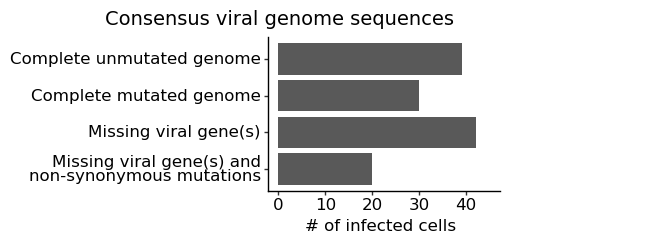

<ggplot: (8787451246333)>

In [20]:
mutated_cell_counts_file = figure_dir+'/'+'mutated_cell_counts_plot.svg'

mutated_cell_counts_plot = (
    p9.ggplot(mutated_cell_counts,
              p9.aes(x='cell_label',
                     y='n_cells',
                     width=0.85)) +
    p9.geom_bar(stat='identity') +
    p9.coord_flip() +
    p9.ggtitle('Consensus viral genome sequences                                 ') +
    p9.labs(x = '', y='# of infected cells') +
    p9.ylim([0,45]) +
    p9.theme(figure_size=(3, 2),
             plot_title=p9.element_text(size=title_size),
             axis_title=p9.element_text(size=axis_label_size),
             axis_text=p9.element_text(size=axis_text_size, color="black"),
             strip_text=p9.element_text(size=facet_label_size),))

mutated_cell_counts_plot.save(filename = mutated_cell_counts_file)
display(mutated_cell_counts_plot)

### Plot number of non-synonymous mutations per cell.

In [74]:
fully_sequenced_cells['nonsynonymous_mutation_count'].value_counts()

0    81
1    37
2    10
3     3
Name: nonsynonymous_mutation_count, dtype: int64

/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 3 x 2 in image.
/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: results/figures/mutations_per_cell.svg


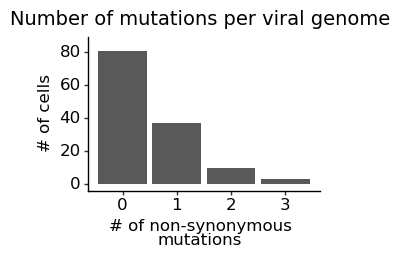

<ggplot: (8787452175330)>

In [77]:
mutations_per_cell_file = figure_dir+'/'+'mutations_per_cell.svg'

mutations_per_cell_plot = (
    p9.ggplot(
        fully_sequenced_cells,
        p9.aes(x='nonsynonymous_mutation_count')) +
    p9.geom_bar() +
    p9.ggtitle(f'Number of mutations per viral genome') +
    p9.labs(x='# of non-synonymous\nmutations',
            y='# of cells') +
    p9.scale_y_continuous(limits=[0,85], breaks=[0,20,40,60,80]) +
    p9.theme(figure_size=(3, 2),
             plot_title=p9.element_text(size=title_size),
             axis_title=p9.element_text(size=axis_label_size),
             axis_text=p9.element_text(size=axis_text_size, color="black"),
             strip_text=p9.element_text(size=facet_label_size),
             legend_box_spacing=0.2,
             legend_title=p9.element_blank()))
mutations_per_cell_plot.save(filename = mutations_per_cell_file)
display(mutations_per_cell_plot)

### Make composite Fig 3
Make a composite figure showing viral genotypes and number of mutations per genome.

In [79]:
fig3_file = figure_dir+'/'+'fig3.svg'

fig3 = (Figure("19cm", "5cm",
       Panel(
           Text("Low MOI viral genome sequences")
       ),
       Panel(
#           Grid(20, 20),
           SVG(mutated_cell_counts_file),
           Text("A", 5, 15, size=fig_letter_size)
       ).move(0,30),
       Panel(
           SVG(mutations_per_cell_file).move(25,0),
           Text("B", 5, 15, size=fig_letter_size)
       ).move(370,30),
       ))
display(fig3)
fig3.save(fig3_file)

## Progeny production measurements
### Plot viral transcription in cells that express both barcoded genes
How does total viral transcription correlate with expressing both viral genes needed for progeny contribution meausrements?

In [23]:
barcoded_cells = wt_infected_cells.query("all_barcoded_genes")
display(barcoded_cells)

,sample,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,n_viral_genes,transcriptome_UMIs_fluHA,transcriptome_UMIs_fluM,...,viral_barcodes_fluNA,freq_supernatant_fluHA,freq_supernatant_fluNA,freq_second_infection_fluHA,freq_second_infection_fluNA,all_viral_genes,missing_viral_genes,virus_fully_sequenced,all_barcoded_genes,sequenced_and_barcoded
8,highMOI,AACAACCGTGATTCTG,infected,wt,54425,2669,0.049040,8,240,1364,...,TCCTAAGTTAGTACCT,0.00002,0.002127,0.000058,0.032429,True,,False,True,barcoded
10,highMOI,AACCACATCTTCCACG,infected,wt,32831,2822,0.085955,8,267,985,...,TATATAAATCAGTGGA,0.000047,0.00001,0.000125,0.000182,True,,False,True,barcoded
11,highMOI,AACCCAATCACTGGGC,infected,wt,19475,4906,0.251913,8,74,2419,...,ATGTTATGTAGATGGA; TGTAATCCGACCTAAA,0.00001,0.00002,0.000141,0.000138,True,,False,True,barcoded
12,highMOI,AACGGGAGTGACAGCA,infected,wt,14727,11112,0.754532,8,2089,6616,...,GTTAAAATAGATTACG,0.00001,0.000264,0.00001,0.00001,True,,False,True,barcoded
13,highMOI,AAGAACAGTACGACTT,infected,wt,51849,4828,0.093117,8,539,2098,...,AGCTTGTCGATGTGTC; TCGTTGAGGAGAAATC; CGTCATACCC...,0.000225,0.000676,0.000859,0.002069,True,,False,True,barcoded
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
911,lowMOI,TTGCGTCCACCCTCTA,infected,wt,160497,1816,0.011315,7,241,678,...,GAGCTCCTGTATTGCC,0.00001,0.00001,0.00001,0.00001,False,PA,True,True,sequenced and barcoded
912,lowMOI,TTGGGATGTAACGATA,infected,wt,161690,9470,0.058569,8,407,4600,...,TAAAAAATGTCTCATG,0.001014,0.001284,0.000154,0.000015,True,,True,True,sequenced and barcoded
914,lowMOI,TTTACCAGTCGCTTAA,infected,wt,114567,1434,0.012517,7,125,609,...,ATTTGGATGTAGGGGC; TTGGAGGAGACCCGTG,0.000106,0.001222,0.00002,0.000029,False,PA,False,True,barcoded
915,lowMOI,TTTCACAAGCCAAGCA,infected,wt,68424,2308,0.033731,6,475,796,...,GGTATCAGTTATTGTT,0.00001,0.00001,0.00001,0.00001,False,NS; PB1,True,True,sequenced and barcoded


/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 3.5 x 3.5 in image.
/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: results/figures/barcoded_cells_plot.svg


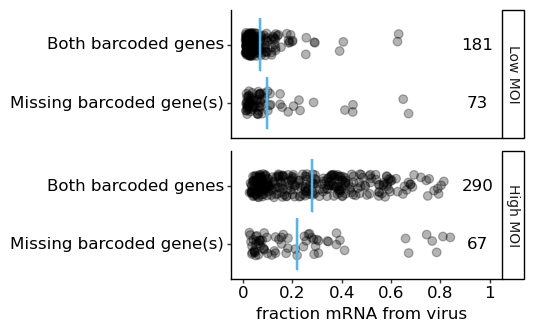

<ggplot: (8787451089279)>

In [24]:
barcoded_cells_file = figure_dir+'/'+'barcoded_cells_plot.svg'

barcoded_cells_plot = (
    p9.ggplot(wt_infected_cells,
               p9.aes(x='all_barcoded_genes',
                      y='frac_viral_UMIs')) +
    p9.geom_jitter(alpha=0.3, size=3, width=0.2) +
    p9.stat_summary(fun_y=np.mean, 
                    fun_ymin=np.mean,
                    fun_ymax=np.mean,
                    geom='crossbar',
                    width=0.9,
                    color=CBPALETTE[2]) +
    p9.geom_text(data=wt_infected_cells.groupby(['sample','all_barcoded_genes']).nunique().reset_index(),
                 mapping=p9.aes(y=0.95,
                                label='cell_barcode'),
                 size=12) +
    p9.facet_grid('sample~', labeller=p9.labeller(sample_labeller)) +
    p9.coord_flip() +
    p9.labs(x='',
            y='fraction mRNA from virus') +
    p9.scale_y_continuous(limits=[0,1], breaks=[0,0.2,0.4,0.6,0.8,1]) +
    p9.scale_x_discrete(labels=['Missing barcoded gene(s)', 'Both barcoded genes']) +
    p9.theme(figure_size=(3.5, 3.5),
             plot_title=p9.element_text(size=title_size),
             axis_title=p9.element_text(size=axis_label_size),
             axis_text=p9.element_text(size=axis_text_size, color="black"),
             strip_text=p9.element_text(size=facet_label_size),
             subplots_adjust={'hspace':0.1}))

barcoded_cells_plot.save(filename = barcoded_cells_file)
display(barcoded_cells_plot)

## Cells with all measurements
### Select subset of cells with complete sequencing and both barcoded viral genes
In the next section, I will calculate progeny contributions for cells that have complete measurements for their experiment. For `highMOI`, this is both barcoded viral genes. For `lowMOI`, this is long-read sequencing and both barcoded viral genes. I want to count how many cells meet these criteria, and how many fail one or both of these criteria.

In [25]:
def select_cells(row):
    row_dict = row.to_dict()
    selected_cell = None
    if row['sample'] == "highMOI":
        selected_cell = row['sequenced_and_barcoded'] == "barcoded"
    elif row['sample'] == "lowMOI":
        selected_cell = row['sequenced_and_barcoded'] == "sequenced and barcoded"
    return selected_cell

wt_infected_cells = (
    wt_infected_cells
    .assign(
        selected_cell=lambda x: x.apply(select_cells, axis=1)))

selected_cells = wt_infected_cells.query('selected_cell == True')
display(selected_cells)

,sample,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,n_viral_genes,transcriptome_UMIs_fluHA,transcriptome_UMIs_fluM,...,freq_supernatant_fluHA,freq_supernatant_fluNA,freq_second_infection_fluHA,freq_second_infection_fluNA,all_viral_genes,missing_viral_genes,virus_fully_sequenced,all_barcoded_genes,sequenced_and_barcoded,selected_cell
8,highMOI,AACAACCGTGATTCTG,infected,wt,54425,2669,0.049040,8,240,1364,...,0.00002,0.002127,0.000058,0.032429,True,,False,True,barcoded,True
10,highMOI,AACCACATCTTCCACG,infected,wt,32831,2822,0.085955,8,267,985,...,0.000047,0.00001,0.000125,0.000182,True,,False,True,barcoded,True
11,highMOI,AACCCAATCACTGGGC,infected,wt,19475,4906,0.251913,8,74,2419,...,0.00001,0.00002,0.000141,0.000138,True,,False,True,barcoded,True
12,highMOI,AACGGGAGTGACAGCA,infected,wt,14727,11112,0.754532,8,2089,6616,...,0.00001,0.000264,0.00001,0.00001,True,,False,True,barcoded,True
13,highMOI,AAGAACAGTACGACTT,infected,wt,51849,4828,0.093117,8,539,2098,...,0.000225,0.000676,0.000859,0.002069,True,,False,True,barcoded,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
910,lowMOI,TTGAGTGTCCTGGGTG,infected,wt,43013,8648,0.201055,8,795,2317,...,0.00013,0.000904,0.00001,0.000014,True,,True,True,sequenced and barcoded,True
911,lowMOI,TTGCGTCCACCCTCTA,infected,wt,160497,1816,0.011315,7,241,678,...,0.00001,0.00001,0.00001,0.00001,False,PA,True,True,sequenced and barcoded,True
912,lowMOI,TTGGGATGTAACGATA,infected,wt,161690,9470,0.058569,8,407,4600,...,0.001014,0.001284,0.000154,0.000015,True,,True,True,sequenced and barcoded,True
915,lowMOI,TTTCACAAGCCAAGCA,infected,wt,68424,2308,0.033731,6,475,796,...,0.00001,0.00001,0.00001,0.00001,False,NS; PB1,True,True,sequenced and barcoded,True


Count number of cells with sequencing, barcoded genes, or both.

In [26]:
sequenced_barcoded_cell_counts = (wt_infected_cells
        .groupby(["sample", "sequenced_and_barcoded", "selected_cell"])
        .aggregate(n_cells=pd.NamedAgg("cell_barcode", "count"))
        .reset_index()
)
sequenced_barcoded_cell_counts['sequenced_and_barcoded'] = (
    sequenced_barcoded_cell_counts['sequenced_and_barcoded']
    .astype('category')
    .cat
    .reorder_categories(['not sequenced or barcoded',
              'barcoded',
              'sequenced',
              'sequenced and barcoded'])
)

### Plot number of cells with or without complete measurements

/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 5 x 1.8 in image.
/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: results/figures/selected_cells_plot.svg


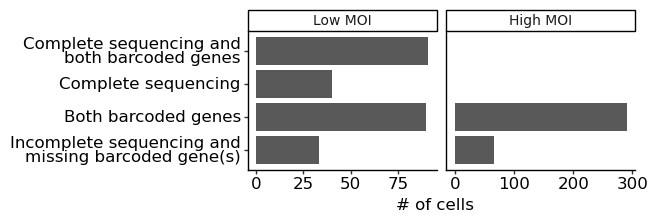

<ggplot: (8787451151635)>

In [27]:
selected_cells_file = figure_dir+'/'+'selected_cells_plot.svg'

selected_cells_plot = (
    p9.ggplot(sequenced_barcoded_cell_counts,
               p9.aes(x='sequenced_and_barcoded',
                      y='n_cells',
                      width=0.85)) +
    p9.geom_bar(stat='identity', position='dodge') +
    p9.facet_grid('~sample',
                  labeller=p9.labeller(cols=sample_labeller),
                  scales='free_x') +
    p9.labs(x='',
            y='# of cells') +
    p9.scale_x_discrete(labels=["Incomplete sequencing and\nmissing barcoded gene(s)",
                                "Both barcoded genes",
                                "Complete sequencing",
                                "Complete sequencing and\nboth barcoded genes"]) +
    p9.coord_flip() +
    p9.theme(figure_size=(5, 1.8),
             plot_title=p9.element_text(size=title_size),
             axis_title=p9.element_text(size=axis_label_size),
             axis_text=p9.element_text(size=axis_text_size, color="black"),
             strip_text=p9.element_text(size=facet_label_size),
             subplots_adjust={'wspace':0.05}))

selected_cells_plot.save(filename = selected_cells_file)
display(selected_cells_plot)

### Plot viral transcription in cells with complete sequencing and both barcoded viral genes
Do the cells that meet these criteria have a different distribution of viral transcription, or are we subsampling the data in a fairly non-biased way?

/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 3.5 x 3.5 in image.
/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: results/figures/complete_measurements_plot.svg


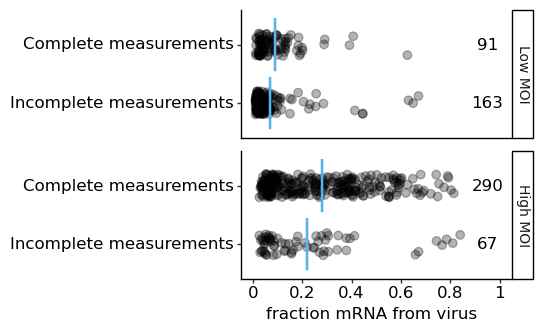

<ggplot: (8787467090502)>

In [28]:
complete_measurements_file = figure_dir+'/'+'complete_measurements_plot.svg'

complete_measurements_plot = (
    p9.ggplot(wt_infected_cells,
               p9.aes(x='selected_cell',
                      y='frac_viral_UMIs')) +
    p9.geom_jitter(alpha=0.3, size=3, width=0.2) +
    p9.stat_summary(fun_y=np.mean, 
                    fun_ymin=np.mean,
                    fun_ymax=np.mean,
                    geom='crossbar',
                    width=0.9,
                    color=CBPALETTE[2]) +
    p9.geom_text(data=pd.DataFrame(sequenced_barcoded_cell_counts.groupby(['sample', 'selected_cell'])['n_cells'].sum().reset_index()),
                 mapping=p9.aes(
                     x='selected_cell',
                     y=0.95,
                     label='n_cells'),
                 size=12) +
    p9.facet_grid('sample~', labeller=p9.labeller(sample_labeller)) +
    p9.coord_flip() +
    p9.labs(x='',
            y='fraction mRNA from virus') +
    p9.scale_y_continuous(limits=[0,1], breaks=[0,0.2,0.4,0.6,0.8,1]) +
    p9.scale_x_discrete(labels=['Incomplete measurements', 'Complete measurements']) +
    p9.theme(figure_size=(3.5, 3.5),
             plot_title=p9.element_text(size=title_size),
             axis_title=p9.element_text(size=axis_label_size),
             axis_text=p9.element_text(size=axis_text_size, color="black"),
             strip_text=p9.element_text(size=facet_label_size),
             subplots_adjust={'hspace':0.1}))

complete_measurements_plot.save(filename = complete_measurements_file)
display(complete_measurements_plot)

### Make composite Fig S4
Assemble a composite figure showing how many cells are sequenced completely, have both barcoded viral genes, and the relationship of these criteria to total viral transcription.

In [29]:
figS4_file = figure_dir+'/'+'figS4.svg'

figS4 = (Figure("24cm", "14cm",
       Panel(
#           Grid(20, 20),
           SVG(barcoded_cells_file).move(15,10),
           Text("A", 0, 20, size=fig_letter_size)),
       Panel(
           SVG(fully_sequenced_file).move(33,50),
           Text("B", 0, 20, size=fig_letter_size)).move(470,0),
       Panel(
           SVG(selected_cells_file).move(0,50),
           Text("C", 0, 20, size=fig_letter_size)).move(0,250),
       Panel(
           SVG(complete_measurements_file).move(10,20),
           Text("D", 0, 20, size=fig_letter_size)).move(470,250),
       ))
display(figS4)
figS4.save(figS4_file)

### How many cells are contributing progeny?
With these data, we can ask a simple question about the progeny population. Among the sequenced, barcoded cells, how many contribute any progeny?

In [30]:
for sample in selected_cells['sample'].unique():
    n_selected_cells = (
        selected_cells.query(f'sample == "{sample}"')
        ['cell_barcode'].nunique())
    print(f'There are {n_selected_cells} in {sample} with complete measurements.')

There are 290 in highMOI with complete measurements.
There are 91 in lowMOI with complete measurements.


In [31]:
(integrated_data[integrated_data['cell_barcode']
                 .isin(selected_cells["cell_barcode"].to_list())]
 .groupby(['sample', 'contributes_progeny_supernatant', 'contributes_progeny_second_infection'])
 ['cell_barcode']
 .nunique())

sample   contributes_progeny_supernatant  contributes_progeny_second_infection
highMOI  False                            False                                    45
                                          True                                     22
         True                             False                                    25
                                          True                                    198
lowMOI   False                            False                                    36
         True                             False                                    14
                                          True                                     41
Name: cell_barcode, dtype: int64

### Calculate progeny contribution of cells with complete sequencing and both barcoded viral genes
Next, I will calculate the contribution of each infected cell to the progeny population. I will normalize the the progeny viral barcode frequences among source and gene (e.g. 'supernatant fluHA'). Then, I will take the geometric mean of both barcoded genes to estimate the progeny contribution for each infected cell:

In [32]:
for condition in ["supernatant", "second_infection"]:
    for gene in barcoded_genes:
        # normalize among selected cells and within barcoded gene
        col = f"freq_{condition}_{gene}"
        sum_col = col + '_sum'
        selected_cells = pd.merge(
            left=selected_cells,
            right=(selected_cells.groupby('sample')[col].sum()
                   .reset_index()
                   .rename(columns={col: sum_col})),
            on='sample',
            how='left',
            validate='many_to_one')
        selected_cells[col] = (
            selected_cells[col] /
            selected_cells[sum_col]
        ).astype(float)
    # calculate geometric mean of normalized values
    mean_col = f"freq_{condition}"
    selected_cells[mean_col] = (
        selected_cells[f"{mean_col}_fluHA"]
        * selected_cells[f"{mean_col}_fluNA"]
    )**(1 / 2)
    # normalize geometric means
    sum_mean_col = mean_col + '_sum'
    selected_cells = pd.merge(
        left=selected_cells,
        right=(selected_cells.groupby('sample')[mean_col].sum()
               .reset_index()
               .rename(columns={mean_col: sum_mean_col})),
        on='sample',
        how='left',
        validate='many_to_one')
    selected_cells[mean_col] = (
        selected_cells[mean_col] /
        selected_cells[sum_mean_col]
    ).astype(float)

display(selected_cells)

,sample,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,n_viral_genes,transcriptome_UMIs_fluHA,transcriptome_UMIs_fluM,...,sequenced_and_barcoded,selected_cell,freq_supernatant_fluHA_sum,freq_supernatant_fluNA_sum,freq_supernatant,freq_supernatant_sum,freq_second_infection_fluHA_sum,freq_second_infection_fluNA_sum,freq_second_infection,freq_second_infection_sum
0,highMOI,AACAACCGTGATTCTG,infected,wt,54425,2669,0.049040,8,240,1364,...,barcoded,True,0.063048,0.084006,0.004330,0.654576,0.089809,0.405327,0.013986,0.515043
1,highMOI,AACCACATCTTCCACG,infected,wt,32831,2822,0.085955,8,267,985,...,barcoded,True,0.063048,0.084006,0.000456,0.654576,0.089809,0.405327,0.001538,0.515043
2,highMOI,AACCCAATCACTGGGC,infected,wt,19475,4906,0.251913,8,74,2419,...,barcoded,True,0.063048,0.084006,0.000297,0.654576,0.089809,0.405327,0.001421,0.515043
3,highMOI,AACGGGAGTGACAGCA,infected,wt,14727,11112,0.754532,8,2089,6616,...,barcoded,True,0.063048,0.084006,0.001078,0.654576,0.089809,0.405327,0.000102,0.515043
4,highMOI,AAGAACAGTACGACTT,infected,wt,51849,4828,0.093117,8,539,2098,...,barcoded,True,0.063048,0.084006,0.008186,0.654576,0.089809,0.405327,0.013562,0.515043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,lowMOI,TTGAGTGTCCTGGGTG,infected,wt,43013,8648,0.201055,8,795,2317,...,sequenced and barcoded,True,0.061856,0.108557,0.006158,0.677996,0.04949,0.152348,0.000249,0.542695
377,lowMOI,TTGCGTCCACCCTCTA,infected,wt,160497,1816,0.011315,7,241,678,...,sequenced and barcoded,True,0.061856,0.108557,0.000180,0.677996,0.04949,0.152348,0.000212,0.542695
378,lowMOI,TTGGGATGTAACGATA,infected,wt,161690,9470,0.058569,8,407,4600,...,sequenced and barcoded,True,0.061856,0.108557,0.020538,0.677996,0.04949,0.152348,0.001035,0.542695
379,lowMOI,TTTCACAAGCCAAGCA,infected,wt,68424,2308,0.033731,6,475,796,...,sequenced and barcoded,True,0.061856,0.108557,0.000180,0.677996,0.04949,0.152348,0.000212,0.542695


### Export CSV of cells with complete sequencing data
To generate the plot of viral genomes, we needed to provide progeny contribution measurements where possible. This is why this task is performed **after** estimating progeny contributions. Cells with complete PacBio data without progeny contribution measurements will have null value.

In [33]:
# Bring in progeny production measurements when available
fully_sequenced_cells_CSV = 'results/pacbio/fully_sequenced_cells.csv'

fully_sequenced_cells = pd.merge(
    left=fully_sequenced_cells,
    right=selected_cells[['sample', 'cell_barcode', 'freq_supernatant', 'freq_second_infection']],
    on=['sample','cell_barcode'],
    how='left',
    validate='one_to_one'
)
display(fully_sequenced_cells)
print(f"Writing fully sequenced cells data to CSV: {fully_sequenced_cells_CSV}")
fully_sequenced_cells.to_csv(fully_sequenced_cells_CSV)

,sample,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,n_viral_genes,transcriptome_UMIs_fluHA,transcriptome_UMIs_fluM,...,viral_mutations,nonsynonymous_mutations,mutation_support,mutated_genes,has_mutations,has_nonsynonymous_mutations,nonsynonymous_mutation_count,cell_label,freq_supernatant,freq_second_infection
0,lowMOI,AAAGGGCTCCGCACTT,infected,wt,128527,3021,0.023505,7,86,735,...,PB2: del168to2007 del2097to2106,"PB2: del168to2007, PB2: del2097to2106",PB2: 1597/1611 1601/1611,PB2,True,True,2,Missing viral gene(s) and\nnon-synonymous muta...,0.012424,0.001218
1,lowMOI,AAAGTCCAGTAGAGTT,infected,wt,75830,15135,0.199591,8,566,7232,...,,,,,False,False,0,Complete unmutated genome,0.000180,0.000212
2,lowMOI,AACCAACAGGGTCTTT,infected,wt,130332,17157,0.131641,8,1347,6280,...,"M: A111C_synonymous, NA: del39to1256, NS: G550...","NA: del39to1256, NS: G550A_G184R, PA: A937C_T313P","M: 436/472, NA: 1483/1550, NS: 48/50, PA: 7/9","M, NA, NS, PA",True,True,3,Complete mutated genome,0.002509,0.000443
3,lowMOI,AAGGAATAGATTGAGT,infected,wt,51455,1667,0.032397,6,3,435,...,,,,,False,False,0,Missing viral gene(s),NaN,NaN
4,lowMOI,AAGGAATAGCATCGAG,infected,wt,91039,3192,0.035062,8,114,1262,...,"NA: del43to43, PB2: T650A_F217Y","NA: del43to43, PB2: T650A_F217Y","NA: 14/14, PB2: 4/4","NA, PB2",True,True,2,Complete mutated genome,0.000483,0.003880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,lowMOI,TTGAGTGTCCTGGGTG,infected,wt,43013,8648,0.201055,8,795,2317,...,,,,,False,False,0,Complete unmutated genome,0.006158,0.000249
127,lowMOI,TTGCGTCCACCCTCTA,infected,wt,160497,1816,0.011315,7,241,678,...,HA: A954G_synonymous,,HA: 15/16,HA,True,False,0,Missing viral gene(s),0.000180,0.000212
128,lowMOI,TTGGGATGTAACGATA,infected,wt,161690,9470,0.058569,8,407,4600,...,,,,,False,False,0,Complete unmutated genome,0.020538,0.001035
129,lowMOI,TTTCACAAGCCAAGCA,infected,wt,68424,2308,0.033731,6,475,796,...,HA: T465A_H155Q,HA: T465A_H155Q,HA: 85/90,HA,True,True,1,Missing viral gene(s) and\nnon-synonymous muta...,0.000180,0.000212


Writing fully sequenced cells data to CSV: results/pacbio/fully_sequenced_cells.csv


### Generate viral genome plot using R script
There is an R script that generates the viral genomes plot using `gggenes`. We call that here using `subprocess.call`.

In [34]:
# call R script to generate viral genomes plot
viral_genomes_file = figure_dir+'/'+'viral_genomes_plot.pdf'
rscript_file = "scripts/viral_genomes_plot.R"
subprocess.call(" ".join(["Rscript", rscript_file, fully_sequenced_cells_CSV, viral_genomes_file]), shell = True)

Warning message:
package ‘ggplot2’ was built under R version 4.1.3 
Warning message:
package ‘gggenes’ was built under R version 4.1.3 
Warning message:
package ‘ggnewscale’ was built under R version 4.1.2 
Coordinate system already present. Adding new coordinate system, which will replace the existing one.
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


0

## Heterogeneity in viral products
### Calculate Gini coefficients
Calculate Gini coefficient for viral transcription, physical progeny production, and infectious progeny production.

In [35]:
gini_coeffs_df = pd.DataFrame()

for sample in wt_infected_cells['sample'].unique():
    total_array = wt_infected_cells.query(f'sample == "{sample}"')['frac_viral_UMIs'].to_numpy()
    total_gini = gini(total_array)
    n_wt_infected_cells = wt_infected_cells.query(f'sample == "{sample}"')['cell_barcode'].nunique()
    print(f"The Gini coefficient for {sample} viral transcription in {n_wt_infected_cells} infected cells is {total_gini:0f}\n")


    distributions = {'viral_transcription': 'frac_viral_UMIs',
                     'physical_progeny_virions': 'freq_supernatant',
                     'infectious_progeny_virions': 'freq_second_infection'}
    gini_coeffs = {'viral_transcription': None,
                   'physical_progeny_virions': None,
                   'infectious_progeny_virions': None,}

    n_selected_cells = selected_cells.query(f'sample == "{sample}"')['cell_barcode'].nunique()                                                  
    print(f"For the {n_selected_cells} {sample} cells with complete measurements:")
    for distribution, variable in distributions.items():
        dist_array = selected_cells.query(f'sample == "{sample}"')[variable].to_numpy()
        gini_coeff = gini(dist_array)
        gini_coeffs[distribution] = gini_coeff
        print(f"{sample} {distribution} has a Gini coefficient of {gini_coeff:0f}")
    print('\n')
    
    # store gini coefficients in dataframe
    sample_gini_df = pd.DataFrame(gini_coeffs, index=[sample])
    sample_gini_df['sample'] = sample
    gini_coeffs_df = pd.concat(
        [gini_coeffs_df, sample_gini_df],
        axis=0)

for col in gini_coeffs_df.columns:
    if '_' in col:
        label_col = col+'_label'
        gini_coeffs_df[label_col] = "Gini="+round(gini_coeffs_df[col], 2).astype(str)

label_y_df = pd.DataFrame({'sample':['lowMOI','highMOI'],
                           'viral_transcription_label_y':[30, 50],
                           'physical_progeny_virions_label_y':[60, 200],
                           'infectious_progeny_virions_label_y':[60, 200]})
gini_coeffs_df = pd.merge(
    left=gini_coeffs_df,
    right=label_y_df,
    on='sample',
    how='outer',
    validate='one_to_one'
)

gini_coeffs_df['sample'] = (
    gini_coeffs_df['sample']
    .astype('category')
    .cat
    .reorder_categories(['lowMOI', 'highMOI'])
)
display(gini_coeffs_df)

The Gini coefficient for highMOI viral transcription in 357 infected cells is 0.421770

For the 290 highMOI cells with complete measurements:
highMOI viral_transcription has a Gini coefficient of 0.402566
highMOI physical_progeny_virions has a Gini coefficient of 0.660641
highMOI infectious_progeny_virions has a Gini coefficient of 0.718355


The Gini coefficient for lowMOI viral transcription in 254 infected cells is 0.539101

For the 91 lowMOI cells with complete measurements:
lowMOI viral_transcription has a Gini coefficient of 0.464415
lowMOI physical_progeny_virions has a Gini coefficient of 0.779920
lowMOI infectious_progeny_virions has a Gini coefficient of 0.874834




,viral_transcription,physical_progeny_virions,infectious_progeny_virions,sample,viral_transcription_label,physical_progeny_virions_label,infectious_progeny_virions_label,viral_transcription_label_y,physical_progeny_virions_label_y,infectious_progeny_virions_label_y
0,0.402566,0.660641,0.718355,highMOI,Gini=0.4,Gini=0.66,Gini=0.72,50,200,200
1,0.464415,0.779920,0.874834,lowMOI,Gini=0.46,Gini=0.78,Gini=0.87,30,60,60


### Plot histograms of viral transcription, physical progeny (supernatant), and infectious progeny (second infection) frequency

/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 3 x 2.5 in image.
/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: results/figures/physical_progeny_plot.svg


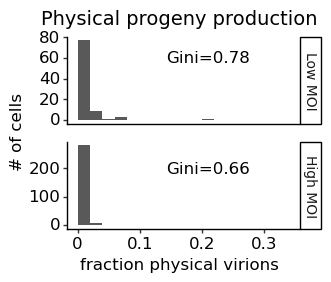

<ggplot: (8787466861740)>

In [36]:
physical_progeny_file = figure_dir+'/'+'physical_progeny_plot.svg'

physical_progeny_plot = (
    p9.ggplot(
        selected_cells,
        p9.aes(x='freq_supernatant')) +
    p9.geom_histogram(breaks=[0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,
                              0.18,0.2,0.22,0.24,0.26,0.28,0.3,0.32,0.34]) +
    p9.ggtitle(f'Physical progeny production') +
    p9.labs(x='fraction physical virions',
            y='# of cells') +
    p9.facet_grid('sample~',
                  labeller=p9.labeller(sample_labeller),
                  scales='free_y') +
    p9.geom_text(data=gini_coeffs_df,
                 mapping=p9.aes(label='physical_progeny_virions_label',
                                x=0.21, y='physical_progeny_virions_label_y'),
                 size=12) +
    p9.theme(figure_size=(3, 2.5),
             plot_title=p9.element_text(size=title_size),
             axis_title=p9.element_text(size=axis_label_size),
             axis_text=p9.element_text(size=axis_text_size, color="black"),
             strip_text=p9.element_text(size=facet_label_size),
             subplots_adjust={'hspace':0.2},
             axis_title_y=p9.element_text(margin={'r':10})
             ))
physical_progeny_plot.save(filename = physical_progeny_file)
display(physical_progeny_plot)

/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 3 x 2.5 in image.
/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: results/figures/infectious_progeny_plot.svg


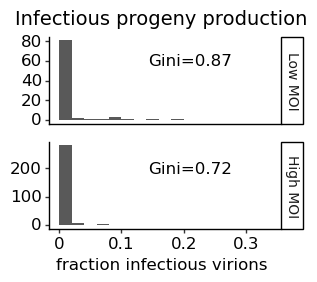

<ggplot: (8787466651730)>

In [37]:
infectious_progeny_file = figure_dir+'/'+'infectious_progeny_plot.svg'

infectious_progeny_plot = (
    p9.ggplot(
        selected_cells,
        p9.aes(x='freq_second_infection')) +
    p9.geom_histogram(breaks=[0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,
                              0.18,0.2,0.22,0.24,0.26,0.28,0.3,0.32,0.34]) +
    p9.ggtitle(f'Infectious progeny production') +
    p9.labs(x='fraction infectious virions',
            y='') +
    p9.geom_text(data=gini_coeffs_df,
                mapping=p9.aes(label='infectious_progeny_virions_label',
                               x=0.21, y='infectious_progeny_virions_label_y'),
                size=12) +
    p9.facet_grid('sample~',
                  labeller=p9.labeller(sample_labeller),
                  scales='free_y')+
    p9.theme(figure_size=(3, 2.5),
             plot_title=p9.element_text(size=title_size),
             axis_title=p9.element_text(size=axis_label_size),
             axis_text=p9.element_text(size=axis_text_size, color="black"),
             strip_text=p9.element_text(size=facet_label_size),
             subplots_adjust={'hspace':0.2}))
infectious_progeny_plot.save(filename = infectious_progeny_file)
display(infectious_progeny_plot)

/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 3 x 2.5 in image.
/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: results/figures/transcription_selected_cells_plot.svg


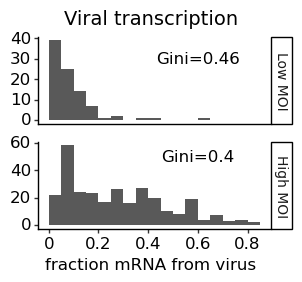

<ggplot: (8787456970795)>

In [38]:
transcription_selected_cells_file = figure_dir+'/'+'transcription_selected_cells_plot.svg'

transcription_selected_cells_plot = (
    p9.ggplot(
        selected_cells,
        p9.aes(x='frac_viral_UMIs')) +
    p9.geom_histogram(breaks=[0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,
                              0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85]) +
    p9.ggtitle(f'Viral transcription') +
    p9.labs(x='fraction mRNA from virus',
            y='') +
    p9.geom_text(data=gini_coeffs_df,
                mapping=p9.aes(label='viral_transcription_label',
                               x=0.6, y='viral_transcription_label_y'),
                size=12) +
    p9.facet_grid('sample~',
                  labeller=p9.labeller(sample_labeller),
                  scales='free_y') +
    p9.theme(figure_size=(3, 2.5),
             plot_title=p9.element_text(size=title_size),
             axis_title=p9.element_text(size=axis_label_size),
             axis_text=p9.element_text(size=axis_text_size, color="black"),
             strip_text=p9.element_text(size=facet_label_size),
             subplots_adjust={'hspace':0.2}))
transcription_selected_cells_plot.save(filename = transcription_selected_cells_file)
display(transcription_selected_cells_plot)

### Make composite Fig 4
Make composite figure of viral transcription, physical progeny production, and infectious progeny production.

In [39]:
fig4_file = figure_dir+'/'+'fig4.svg'

fig4 = (Figure("20cm", "6cm",
       Panel(
#           Grid(20, 20),
           SVG(physical_progeny_file).move(15,0),
           Text("A", 5, 15, size=fig_letter_size)),
       Panel(
           SVG(infectious_progeny_file).move(15,0),
           Text("B", 5, 15, size=fig_letter_size)).move(260,0),
       Panel(
           SVG(transcription_selected_cells_file).move(15,0),
           Text("C", 5, 15, size=fig_letter_size)).move(520,0),
       ))
display(fig4)
fig4.save(fig4_file)

### Calculate cumulative sum of viral products
How many cells does it take to contribute half of the transcripts or progeny? Note that in this dataframe I will calculate the cumulative sum on the absolute number of viral UMIs across all cells, rather than the fraction of viral UMIs within a cell (which is the metric I use for other plots).

In [40]:
cumulative_df = selected_cells[['sample', 'cell_barcode', 'viral_UMIs', 'freq_supernatant', 'freq_second_infection']]

cumulative_df = pd.merge(
    left=cumulative_df,
    right=(cumulative_df.groupby('sample')['viral_UMIs'].sum()
           .reset_index()
           .rename(columns={'viral_UMIs': 'viral_UMIs_sum'})),
    on='sample',
    how='left',
    validate='many_to_one')
cumulative_df['viral_UMIs'] = (
    cumulative_df['viral_UMIs'] /
    cumulative_df['viral_UMIs_sum'])

cumsum_list = list()
for col in ['viral_UMIs', 'freq_supernatant', 'freq_second_infection']:
    for sample in cumulative_df['sample'].unique():
        temp_df = pd.DataFrame(
            cumulative_df
            .query(f'sample == "{sample}"')
            .sort_values(by=col, ascending=False)
            .reset_index()
            [col]
            .cumsum())
        temp_df['sample'] = sample
        cumsum_list.append(temp_df)
           
cumsum_df = (
    pd.concat(cumsum_list, axis=0).reset_index()
    .melt(id_vars=['sample','index'],
          var_name='source',
          value_name='cumulative_sum'))
cumsum_df['index'] = cumsum_df['index'] + 1 # 1-base indexing for cell number
cumsum_df['sample'] = (
    cumsum_df['sample']
    .astype('category')
    .cat
    .reorder_categories(['lowMOI', 'highMOI'])
)

cumsum_df['source'] = (
    cumsum_df['source']
    .astype('category')
    .cat
    .reorder_categories(['viral_UMIs',
                         'freq_supernatant',
                         'freq_second_infection'])
)
for sample in cumsum_df['sample'].unique():
    for source in cumsum_df['source'].unique():
        temp_df = (cumsum_df.query(f'sample == "{sample}" and '
                                f'source == "{source}" and '
                                'cumulative_sum > 0.5').min())
        print(sample, source, temp_df['index'], temp_df['cumulative_sum'])

highMOI viral_UMIs 69.0 0.5042174208853784
highMOI freq_supernatant 25.0 0.5029384686392034
highMOI freq_second_infection 19.0 0.5036287315978659
lowMOI viral_UMIs 23.0 0.5090066402459137
lowMOI freq_supernatant 6.0 0.5121561875492372
lowMOI freq_second_infection 4.0 0.5309764633427617


/tmp/ipykernel_52787/49759850.py:51: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/tmp/ipykernel_52787/49759850.py:51: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/tmp/ipykernel_52787/49759850.py:51: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/tmp/ipykernel_52787/49759850.py:51: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reducti

### Plot cumulative sum curves

/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 4 in image.
/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: results/figures/cumulative_sum_plot.svg
/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_point : Removed 2286 rows containing missing values.
/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_point : Removed 2286 rows containing missing values.


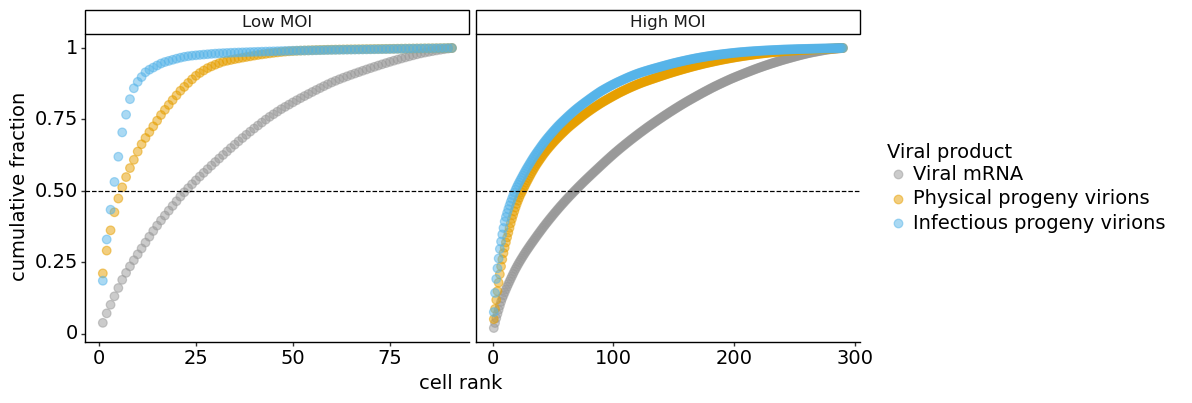

<ggplot: (8787466540674)>

In [41]:
cumulative_sum_file = figure_dir+'/'+'cumulative_sum_plot.svg'

cumulative_sum_plot = (
    p9.ggplot() +
    p9.geom_point(cumsum_df,
                  p9.aes(x='index',
                         y='cumulative_sum',
                         color='source'),
                  alpha=0.5,
                  size=3) +
    p9.geom_hline(yintercept=0.5, linetype='dashed') +
    p9.facet_grid('~sample',
                  labeller=p9.labeller(cols=sample_labeller),
                  scales='free_x', ) +
    p9.labs(x='cell rank', 
            y='cumulative fraction',
            color='Viral product') +
    p9.scale_color_manual(values=CBPALETTE,
                          labels=['Viral mRNA',
                                  'Physical progeny virions',
                                  'Infectious progeny virions']) +
    p9.theme(figure_size=(10, 4),
             legend_position='right',
             legend_title=p9.element_text(size=14),
             legend_text=p9.element_text(size=14),
             axis_title=p9.element_text(size=14),
             axis_text=p9.element_text(size=14, color="black"),
             strip_text=p9.element_text(size=12)))
cumulative_sum_plot.save(filename = cumulative_sum_file)
display(cumulative_sum_plot)

## Transcription-progeny production relationships
### Modify df with sequenced and barcoded cells data for better plotting
I will make modifications to a copy of the dataframe with sequenced and barcoded cells for optimal plotting. Specifically, I will manually adjust the viral transcription values of a few cells by a small amount (jitter) so that they can be plot without overlaying each other.

In [42]:
transcription_progeny_df = selected_cells.copy()
transcription_progeny_df['frac_viral_UMIs_adjusted'] = (
    transcription_progeny_df['frac_viral_UMIs']
)
# Jitter two cells right around 0.3 in sample "lowMOI"
transcription_progeny_df.loc[351, 'frac_viral_UMIs_adjusted'] = (
    transcription_progeny_df.loc[351]['frac_viral_UMIs'] * 1.02
)
transcription_progeny_df.loc[367, 'frac_viral_UMIs_adjusted'] = (
    transcription_progeny_df.loc[367]['frac_viral_UMIs'] * 0.98
)

display(transcription_progeny_df
        .query('sample == "lowMOI"')
        [['cell_barcode',
          'frac_viral_UMIs',
          'frac_viral_UMIs_adjusted',
          'present_fluNS']]
        .sort_values(by='frac_viral_UMIs', ascending=False)
        .head(12))

,cell_barcode,frac_viral_UMIs,frac_viral_UMIs_adjusted,present_fluNS
344,GTCATTTGTCTACACA,0.626158,0.626158,False
357,TCAAGTGCAATAGGAT,0.406549,0.406549,False
316,CGGACACGTCGTGGTC,0.391652,0.391652,True
340,GTAGAAATCATGGATC,0.291269,0.291269,False
356,TATTTCGGTGCCTAAT,0.288597,0.288597,False
376,TTGAGTGTCCTGGGTG,0.201055,0.201055,True
291,AAAGTCCAGTAGAGTT,0.199591,0.199591,True
374,TTACCATGTTGCTTGA,0.192991,0.192991,False
323,CTCAACCCACCCATAA,0.189103,0.189103,True
362,TCGACCTGTGGTCTGC,0.185083,0.185083,True


I will also add annotations that I will use for future plots that label the viral genotypes and whether or not the cells express the influenza NS gene.

First bring in genome information for cells with pacbio sequencing:

In [43]:
transcription_progeny_df = pd.merge(
    left=transcription_progeny_df,
    right=fully_sequenced_cells[['sample','cell_barcode','cell_label']],
    on=['sample','cell_barcode'],
    how='left',
    validate='one_to_one'
)
display(transcription_progeny_df.query('sample=="lowMOI"')[['sample','cell_barcode','cell_label']].head())

,sample,cell_barcode,cell_label
290,lowMOI,AAAGGGCTCCGCACTT,Missing viral gene(s) and\nnon-synonymous muta...
291,lowMOI,AAAGTCCAGTAGAGTT,Complete unmutated genome
292,lowMOI,AACCAACAGGGTCTTT,Complete mutated genome
293,lowMOI,AAGGAATAGCATCGAG,Complete mutated genome
294,lowMOI,AATCGTGGTACTGAGG,Missing viral gene(s)


In [44]:
def label_genome_plot(row):
    if row['sample'] == "lowMOI":
        if row['cell_label'] == "Complete unmutated genome":
            return row['cell_label']
        elif row['cell_label'] == "Complete mutated genome":
            return row['cell_label']
        else:
            return "Missing viral gene(s)"
    elif row['sample'] == "highMOI":
        if row['all_viral_genes'] == True:
            return "Complete genome"
        else:
            return "Missing viral gene(s)"

transcription_progeny_df = (
    transcription_progeny_df
    .assign(genome_label=lambda x: x.apply(label_genome_plot, axis=1))
)
transcription_progeny_df['genome_label'] = (
    transcription_progeny_df['genome_label']
    .astype('category')
    .cat
    .reorder_categories(['Complete unmutated genome',
                         'Complete mutated genome',
                         'Complete genome',
                         'Missing viral gene(s)'])
)
display(transcription_progeny_df['genome_label'].value_counts())

Complete genome              245
Missing viral gene(s)         69
Complete unmutated genome     38
Complete mutated genome       29
Name: genome_label, dtype: int64

I will copy the `present_fluNS` column with descriptive strings instead of True/False:

In [45]:
def present_fluNS_string(row):
    if row['present_fluNS'] == True:
        return "Expresses NS"
    else:
        return "Does not express NS"

transcription_progeny_df = (
    transcription_progeny_df
    .assign(present_fluNS_string=lambda x: x.apply(present_fluNS_string, axis = 1))
)

transcription_progeny_df.groupby(['sample','present_fluNS', 'present_fluNS_string'])['cell_barcode'].nunique()

sample   present_fluNS  present_fluNS_string
lowMOI   False          Does not express NS      13
                        Expresses NS              0
         True           Does not express NS       0
                        Expresses NS             78
highMOI  False          Does not express NS      15
                        Expresses NS              0
         True           Does not express NS       0
                        Expresses NS            275
Name: cell_barcode, dtype: int64

### Plot transcription-progeny production relationship
Plot the relationship between viral transcription and progeny produciton. I will produce both an SVG version for the manuscript and an HTML version for uploading to the web.

Altair variables

In [46]:
freq_cols = [f"freq_{condition}" for condition in ["supernatant", "second_infection"]]
y_label = {"freq_supernatant": "fraction physical progeny",
           "freq_second_infection": "fraction infectious progeny"}

cell_selector = alt.selection_single(on='mouseover', empty='none')

# Colors and shapes
present_fluNS_values = ["Does not express NS", "Expresses NS"]
present_fluNS_shapes = ["triangle", "circle"]

# Selectors

NS_selector = alt.selection_single(
    fields=["present_fluNS_string"],
    bind=alt.binding_select(
        name="Expresses NS\t",
        options=[None,
                 "Does not express NS",
                 "Expresses NS"],
        labels=["All",
                "Does not express NS",
                "Expresses NS"]
    ),
)

Plot low MOI sample

In [47]:
# Files and variables
lowMOI_transcription_progeny_file = figure_dir+'/'+'lowMOI_transcription_progeny_plot.svg'
lowMOI_transcription_progeny_interactive_file = 'docs/_includes/lowMOI_transcription_progeny_interactive.html'

# Colors and shapes
genome_label_values = ["Complete unmutated genome",
                 "Complete mutated genome",
                 "Missing viral gene(s)"]
genome_label_colors = ["#0072B2", "#999999", "#FF5349"] # Verified cb-readable

# Selectors
genotype_selector = alt.selection_single(
    fields=["genome_label"],
    bind=alt.binding_select(
        name="Viral genotype\t",
        options=[None,
                 "Complete unmutated genome",
                 "Complete mutated genome",
                 "Missing viral gene(s)"],
        labels=["All genomes",
                "Complete unmutated genome",
                "Complete mutated genome",
                "Missing viral gene(s)"]
    ),
)

# Build charts
lowMOI_transcription_progeny_charts = []
for freq_col in freq_cols:
    lowMOI_transcription_progeny_charts.append(
        alt.Chart(transcription_progeny_df.query(f'sample == "lowMOI"'))
        .encode(
            x=alt.X("frac_viral_UMIs_adjusted",
                    scale=alt.Scale(domain=(0, 0.7)),
                    axis=alt.Axis(title='fraction mRNA from virus')),
            y=alt.Y(freq_col,
                    sort=[False, True],
                    scale=alt.Scale(domain=(0, 0.22), bins=[0,0.05,0.1,0.15,0.2]),
                    axis=alt.Axis(title=f'{y_label[freq_col]}')),
            tooltip=["cell_barcode", alt.Tooltip("frac_viral_UMIs", format='.2g'),
                     "total_UMIs", "missing_viral_genes",
#                     "mutated_genes",
                     *[alt.Tooltip(c, format='.2g') for c in freq_cols],
#                     "viral_mutations", "mutation_support",
                    ],
            color=alt.Color("genome_label",
                            legend=alt.Legend(title="Viral genotype",
                                              orient='left',
                                              direction='vertical',
                                              titleFontSize=16,
                                              titleFontWeight="normal",
                                              titleAnchor='start',
                                              labelFontSize=16,
                                              symbolStrokeWidth=0,
                                              symbolSize=120,
                                              labelLimit=300),
                            scale=alt.Scale(domain=genome_label_values,
                                            range=genome_label_colors)),
            shape=alt.Shape("present_fluNS_string",
                            legend=alt.Legend(title="Expresses NS",
                                              orient='left',
                                              direction='vertical',
                                              titleFontSize=16,
                                              titleFontWeight="normal",
                                              titleAnchor='start',
                                              labelFontSize=16,
                                              symbolStrokeWidth=0,
                                              symbolSize=120),
                            scale=alt.Scale(domain=present_fluNS_values,
                                            range=present_fluNS_shapes)),
            strokeWidth=alt.condition(cell_selector, alt.value(2), alt.value(0)),
            opacity=alt.condition(
                cell_selector,
                alt.value(1),
                alt.value(0.75),
            ),
            size=alt.value(50),
        )
        .mark_point(filled=True, stroke="black")
        .properties(width=300, height=300)
    )
               
row1 = (alt.hconcat(*lowMOI_transcription_progeny_charts[0:2],
                    spacing=30))

lowMOI_transcription_progeny_plot = (
    (row1)
    .configure_view(strokeWidth=0)
    .add_selection(cell_selector,
                   genotype_selector,
                   NS_selector)
    .transform_filter(genotype_selector)
    .transform_filter(NS_selector)
    .configure_axis(grid=False,
                    titleFontSize=16,
                    titleFontWeight="normal",
                    labelFontSize=16,
                    titlePadding=10)
    .properties(title="Low MOI")
    .configure_title(anchor='start',
                     fontSize=18,
                     fontWeight="normal")
)

display(lowMOI_transcription_progeny_plot)
altair_saver.save(lowMOI_transcription_progeny_plot, lowMOI_transcription_progeny_file)
lowMOI_transcription_progeny_plot.save(lowMOI_transcription_progeny_interactive_file)

alt.HConcatChart(...)

Nice scale option altair

In [48]:
# Files and variables
highMOI_transcription_progeny_file = figure_dir+'/'+'highMOI_transcription_progeny_plot.svg'
highMOI_transcription_progeny_interactive_file = 'docs/_includes/highMOI_transcription_progeny_interactive.html'

# Colors and shapes
genome_label_values = ["Complete genome",
                       "Missing viral gene(s)"]
genome_label_colors = ["#999999", "#FF5349"] # Verified cb-readable

# Selectors
genotype_selector = alt.selection_single(
    fields=["genome_label"],
    bind=alt.binding_select(
        name="Viral genotype\t",
        options=[None,
                 "Complete genome",
                 "Missing viral gene(s)"],
        labels=["All genomes",
                "Complete genome",
                "Missing viral gene(s)"]
    ),
)

# Build charts
highMOI_transcription_progeny_chart=(
    alt.Chart(transcription_progeny_df.query(f'sample == "highMOI"'))
    .encode(
        x=alt.X("frac_viral_UMIs_adjusted",
                scale=alt.Scale(domain=(0, 0.85)),
                axis=alt.Axis(title='fraction mRNA from virus')),
        y=alt.Y("freq_supernatant",
                sort=[False, True],
                scale=alt.Scale(domain=(0, 0.05), bins=[0,0.01,0.02,0.03,0.04,0.05]),
                axis=alt.Axis(title=f'{y_label["freq_supernatant"]}', format='.1g')),
        tooltip=["cell_barcode", alt.Tooltip("frac_viral_UMIs", format='.2g'),
                 "total_UMIs", "missing_viral_genes",
#                     "mutated_genes",
                 alt.Tooltip('freq_supernatant', format='.2g'),
#                     "viral_mutations", "mutation_support",
                ],
        color=alt.Color("genome_label",
                        legend=alt.Legend(title="Viral genotype",
                                          orient='left',
                                          direction='vertical',
                                          titleFontSize=16,
                                          titleFontWeight="normal",
                                          titleAnchor='start',
                                          labelFontSize=16,
                                          symbolStrokeWidth=0,
                                          symbolSize=120,
                                          labelLimit=200),
                        scale=alt.Scale(domain=genome_label_values,
                                        range=genome_label_colors)),
        shape=alt.Shape("present_fluNS_string",
                        legend=alt.Legend(title="Expresses NS",
                                          orient='left',
                                          direction='vertical',
                                          titleFontSize=16,
                                          titleFontWeight="normal",
                                          titleAnchor='start',
                                          labelFontSize=16,
                                          symbolStrokeWidth=0,
                                          symbolSize=120),
                        scale=alt.Scale(domain=present_fluNS_values,
                                        range=present_fluNS_shapes)),
        strokeWidth=alt.condition(cell_selector, alt.value(2), alt.value(0)),
        opacity=alt.condition(
            cell_selector,
            alt.value(1),
            alt.value(0.75),
        ),
        size=alt.value(50)
    )
    .mark_point(filled=True, stroke="black")
    .properties(width=300, height=300)
)

highMOI_transcription_progeny_plot = (
    highMOI_transcription_progeny_chart
    .configure_view(strokeWidth=0)
    .add_selection(cell_selector,
                   genotype_selector,
                   NS_selector)
    .transform_filter(genotype_selector)
    .transform_filter(NS_selector)
    .configure_axis(grid=False,
                    titleFontSize=16,
                    titleFontWeight="normal",
                    labelFontSize=16,
                    titlePadding=10)
    .properties(title="High MOI")
    .configure_title(anchor='start',
                     fontSize=18,
                     fontWeight="normal")
)

display(highMOI_transcription_progeny_plot)
altair_saver.save(highMOI_transcription_progeny_plot, highMOI_transcription_progeny_file)
highMOI_transcription_progeny_plot.save(highMOI_transcription_progeny_interactive_file)

alt.Chart(...)

## Examine effect of missing viral genes on transcription and progeny production
### Label cells based on missing viral genes
Simplify missing viral gene information. Categorize cells as expressing all viral genes, missing NS, or missing another gene(s).

In [49]:
def label_missing_NS(row):
    if row['all_viral_genes'] == True:
        return "All viral genes"
    elif row['present_fluNS'] == False:
        return "Missing NS gene"
    else:
        return "Missing other viral gene(s)"

transcription_progeny_df = (
    transcription_progeny_df
    .assign(
        missing_NS=lambda x: x.apply(label_missing_NS, axis=1)))

transcription_progeny_df['missing_NS'] = (
    transcription_progeny_df['missing_NS']
    .astype('category')
    .cat
    .reorder_categories(['Missing other viral gene(s)',
                         'Missing NS gene',
                         'All viral genes'])
)

display(transcription_progeny_df.groupby(['sample','missing_NS'])['cell_barcode'].nunique())

sample   missing_NS                 
lowMOI   Missing other viral gene(s)     11
         Missing NS gene                 13
         All viral genes                 67
highMOI  Missing other viral gene(s)     30
         Missing NS gene                 15
         All viral genes                245
Name: cell_barcode, dtype: int64

### Plot the viral transcription based on missing viral genes

/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 5 x 1.5 in image.
/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: results/figures/missing_NS_transcription_plot.svg


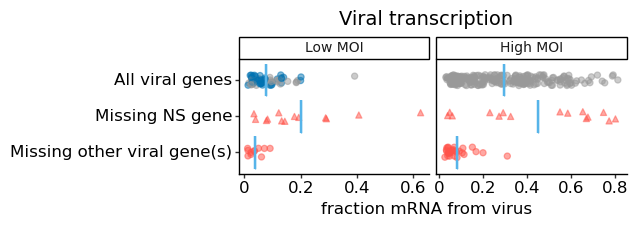

<ggplot: (8787451026080)>

In [50]:
missing_NS_transcription_file = figure_dir+'/'+'missing_NS_transcription_plot.svg'

missing_NS_transcription_plot = (
    p9.ggplot(transcription_progeny_df,
               p9.aes(x='missing_NS',
                      y='frac_viral_UMIs',
                      color='genome_label',
                      shape='present_fluNS_string')) +
    p9.geom_jitter(alpha=0.5, size=2, width=0.15) +
    p9.stat_summary(fun_y=np.mean, 
                    fun_ymin=np.mean,
                    fun_ymax=np.mean,
                    geom='crossbar',
                    width=0.9,
                    color=CBPALETTE[2]) +
    p9.facet_grid('~sample', labeller=p9.labeller(cols=sample_labeller),
                  scales='free_x') +
    p9.ggtitle('Viral transcription') +
    p9.coord_flip() +
    p9.labs(x='',
            y='fraction mRNA from virus') +
    p9.theme(figure_size=(5,1.5),
             plot_title=p9.element_text(size=title_size),
             axis_title=p9.element_text(size=axis_label_size),
             axis_text=p9.element_text(size=axis_text_size, color="black"),
             strip_text=p9.element_text(size=facet_label_size)) +
    p9.scale_color_manual(["#0072B2", "#999999", "#999999", "#FF5349"], guide=False) +
    p9.scale_shape_manual(["^", "o"], guide=False))

missing_NS_transcription_plot.save(filename = missing_NS_transcription_file)
display(missing_NS_transcription_plot)

In [51]:
# missing_NS_transcription_swarm_file = figure_dir+'/'+'missing_NS_transcription_swarm_plot.svg'

# # Figure theme
# fig, ax = plt.subplots()
# fig.set_size_inches(5, 2.2)

# missing_NS_transcription_swarm_plot = (
#     sns.swarmplot(data=transcription_progeny_df,
#                   x='frac_viral_UMIs',
#                   y='missing_NS',
#                   order=['All viral genes', 'Missing NS gene', 'Missing other viral gene(s)'],
#                   palette=['#4F4F4F', '#4F4F4F', '#4F4F4F'],
#                   size=4))
# # Add mean lines
# sns.boxplot(
#     ax=missing_NS_transcription_swarm_plot,
#     data=transcription_progeny_df,
#     x="frac_viral_UMIs",
#     y="missing_NS",
#     order=['All viral genes', 'Missing NS gene', 'Missing other viral gene(s)'],
#     showmeans=True,
#     meanline=True,
#     meanprops={'color': CBPALETTE[2], 'ls': '-', 'lw': 1},
#     medianprops={'visible': False},
#     whiskerprops={'visible': False},
#     zorder=10,
#     showfliers=False,
#     showbox=False,
#     showcaps=False,)

# # Figure theme
# (missing_NS_transcription_swarm_plot
#  .set(ylabel=None,
#       title='Viral transcription'))
# sns.despine()

# plt.tight_layout()
# fig.savefig(fname = missing_NS_transcription_swarm_file)
# display(missing_NS_transcription_swarm_plot)

### Calculate statistical significance of missing viral genes on viral transcription
Check whether cells missing NS have statistically significant difference in viral transcription.  
Since these data are not normally distributed, I will shuffle the group labels to see how often you get a difference of the size observed by chance.

In [ ]:
random.seed(2022) # set seed so results are reproducible
n_simulations = 5000 # number of simulations to run to build the null distribution

for sample in transcription_progeny_df['sample'].unique():
    diffs = list()
    print(f'Calculating distribution for {sample}.')
    shuffle_df = (transcription_progeny_df.query(f'sample == "{sample}"')
                  [['missing_NS','frac_viral_UMIs']])
    obs_missing_NS_mean = np.mean(shuffle_df
                                  .query('missing_NS == "Missing NS gene"')
                                  ['frac_viral_UMIs'])
    obs_all_genes_mean = np.mean(shuffle_df
                                 .query('missing_NS == "All viral genes"')
                                 ['frac_viral_UMIs'])
    obs_diff = obs_missing_NS_mean - obs_all_genes_mean
    print(f'The observed difference between cells missing the NS gene and '
          f'cells expressing all viral genes is {obs_diff:0f}')
    for i in range(0,n_simulations):
        shuffled_groups = (
            random.sample(shuffle_df['missing_NS'].to_list(),
                          len(shuffle_df['missing_NS'].to_list())))
        shuffle_df['missing_NS'] = shuffled_groups
        missing_NS_mean = np.mean(shuffle_df
                                  .query('missing_NS == "Missing NS gene"')
                                  ['frac_viral_UMIs'])
        all_genes_mean = np.mean(shuffle_df
                                 .query('missing_NS == "All viral genes"')
                                 ['frac_viral_UMIs'])
        diff = missing_NS_mean - all_genes_mean
        diffs.append(diff)
    diffs_df = pd.DataFrame(diffs, columns=['diff'])
    diffs_df['abs_diff'] = abs(diffs_df['diff'])
    diffs_df['gt_eq_obs'] = diffs_df['abs_diff'] >= obs_diff
    p = (len(diffs_df.query('gt_eq_obs == True')) /
         len(diffs_df))
    print(f'{p*100}% of simulations find a difference greater than the one observed.')
    diffs_null_plot = (
        p9.ggplot(diffs_df,
                  p9.aes(x='diff',
                         fill='gt_eq_obs')) +
        p9.geom_histogram(bins=20) +
        p9.geom_vline(xintercept=obs_diff,
                      linetype='dashed',
                      color='red') +
        p9.ggtitle(f'{n_simulations} random simulations\n'
                   'Missing NS gene - All viral genes') +
        p9.labs(x='difference in frac_viral_UMIs',
                y='') +
        p9.theme(figure_size=(3, 2.5),
                 plot_title=p9.element_text(size=12),
                 axis_title=p9.element_text(size=12),
                 axis_text=p9.element_text(size=10, color="black"),
                 legend_title=p9.element_text(size=12),
                 legend_title_align='center') +
        p9.scale_fill_manual([CBPALETTE[0],CBPALETTE[2]]))
    display(diffs_null_plot)

### Plot the progeny production based on missing viral genes

In [ ]:
missing_NS_progeny_file = figure_dir+'/'+'missing_NS_progeny_plot.svg'

missing_NS_progeny_plot = (
    p9.ggplot(transcription_progeny_df,
               p9.aes(x='missing_NS',
                      y='freq_supernatant',
                      color="genome_label",
                      shape="present_fluNS_string")) +
    p9.geom_jitter(alpha=0.5, size=2, width=0.15) +
    p9.stat_summary(fun_y=np.mean, 
                    fun_ymin=np.mean,
                    fun_ymax=np.mean,
                    geom='crossbar',
                    width=0.9,
                    color=CBPALETTE[2]) +
    p9.facet_grid('~sample', labeller=p9.labeller(cols=sample_labeller),
                  scales='free_x') +
    p9.ggtitle('Viral progeny production') +
    p9.coord_flip() +
    p9.labs(x='',
            y='fraction physical progeny') +
    p9.theme(figure_size=(5, 1.5),
             plot_title=p9.element_text(size=title_size),
             axis_title=p9.element_text(size=axis_label_size),
             axis_text=p9.element_text(size=axis_text_size, color="black"),
             strip_text=p9.element_text(size=facet_label_size)) +
    p9.scale_color_manual(["#0072B2", "#999999", "#999999", "#FF5349"], guide=False) +
    p9.scale_shape_manual(["^", "o"], guide=False))

missing_NS_progeny_plot.save(filename = missing_NS_progeny_file)
display(missing_NS_progeny_plot)

In [ ]:
# missing_NS_progeny_swarm_file = figure_dir+'/'+'missing_NS_progeny_swarm_plot.svg'

# # Figure theme
# fig, ax = plt.subplots()
# fig.set_size_inches(3.1, 2.2)

# missing_NS_progeny_swarm_plot = (
#     sns.swarmplot(data=transcription_progeny_df,
#                   x='freq_supernatant',
#                   y='missing_NS',
#                   order=['All viral genes', 'Missing NS gene', 'Missing other viral gene(s)'],
#                   palette=['#4F4F4F', '#4F4F4F', '#4F4F4F'],
#                   size=4))
# # Add mean lines
# sns.boxplot(
#     ax=missing_NS_progeny_swarm_plot,
#     data=transcription_progeny_df,
#     x="freq_supernatant",
#     y="missing_NS",
#     order=['All viral genes', 'Missing NS gene', 'Missing other viral gene(s)'],
#     showmeans=True,
#     meanline=True,
#     meanprops={'color': CBPALETTE[2], 'ls': '-', 'lw': 1},
#     medianprops={'visible': False},
#     whiskerprops={'visible': False},
#     zorder=10,
#     showfliers=False,
#     showbox=False,
#     showcaps=False,)

# # Figure theme
# (missing_NS_progeny_swarm_plot
#  .set(ylabel=None,
#       yticklabels=[],
#       title='Viral progeny production'))
# sns.despine()

# plt.tight_layout()
# fig.savefig(fname = missing_NS_progeny_swarm_file)
# display(missing_NS_progeny_swarm_plot)

### Make composite Fig 5
Make composite figure showing viral transcription and progeny production, the effect of missing viral genes, and the heterogeneity of progeny production in cells with complete, unmutated viral genomes.

In [ ]:
fig5_file = figure_dir+'/'+'fig5.svg'

fig5 = (Figure("33cm", "24cm",
       Panel(
#           Grid(20, 20),
           SVG(lowMOI_transcription_progeny_file).scale(1.1).move(0,30),
           Text("Physical progeny production", 410, 20, size=16),
           Text("Infectious progeny production", 840, 20, size=16),
           Text("A", 5, 15, size=18)
           ),
       Panel(
           SVG(highMOI_transcription_progeny_file).scale(1.1).move(0,30),
           Text("Physical progeny production", 320, 20, size=16),
           Text("B", 5, 15, size=18)).move(0,450),
       Panel(
           SVG(missing_NS_transcription_file).scale(1.3).move(0,10),
           Text("C", 5, 15, size=18)).move(640,450),
       Panel(
           SVG(missing_NS_progeny_file).scale(1.3),
           Text("D", 5, 15, size=18)).move(640,680),
       ))
display(fig5)
fig5.save(fig5_file)

## Compare the progeny production distributions of all infected cells to cells with complete, unmutated viral genomes
### Calculate Gini coefficients for cells with complete, unmuated viral genomes for trial 3 sample

In [ ]:
lowMOI_unmutated_distributions = {'viral_transcription': 'frac_viral_UMIs',
                 'physical_progeny_virions': 'freq_supernatant',
                 'infectious_progeny_virions': 'freq_second_infection'}
lowMOI_unmutated_gini_coeffs = {'viral_transcription': None,
               'physical_progeny_virions': None,
               'infectious_progeny_virions': None,}

print("For lowMOI, for the "+str(transcription_progeny_df.query('sample == "lowMOI" and genome_label == "Complete unmutated genome"')['cell_barcode'].nunique())+" unmutated cells with complete progeny measurements and complete sequencing:")
for distribution, variable in distributions.items():
    dist_array = (transcription_progeny_df
                  .query('sample == "lowMOI" and genome_label == "Complete unmutated genome"')
                  [variable]
                  .to_numpy())
    gini_coeff = gini(dist_array)
    lowMOI_unmutated_gini_coeffs[distribution] = gini_coeff
    print(f"{distribution} has a Gini coefficient of {gini_coeff:0f}")

### Calculate Gini coefficients for cells with complete viral genomes for trial 1 sample

In [ ]:
highMOI_complete_distributions = {'viral_transcription': 'frac_viral_UMIs',
                 'physical_progeny_virions': 'freq_supernatant',
                 'infectious_progeny_virions': 'freq_second_infection'}
highMOI_complete_gini_coeffs = {'viral_transcription': None,
               'physical_progeny_virions': None,
               'infectious_progeny_virions': None,}

print("For highMOI, for the "+str(transcription_progeny_df.query('sample == "highMOI" and genome_label == "Complete genome"')['cell_barcode'].nunique())+" cells with complete progeny measurements and complete viral genomes:")
for distribution, variable in distributions.items():
    dist_array = (transcription_progeny_df
                  .query('sample == "highMOI" and genome_label == "Complete genome"')
                  [variable]
                  .to_numpy())
    gini_coeff = gini(dist_array)
    highMOI_complete_gini_coeffs[distribution] = gini_coeff
    print(f"{distribution} has a Gini coefficient of {gini_coeff:0f}")

### Plot physical progeny production in all infected cells
Make another plot of progeny production in infected cells, formatted for use in a composite figure. This is the same information that is displayed in figure 4.

In [ ]:
lowMOI_all_physical_progeny_file = figure_dir+'/'+'lowMOI_all_physical_progeny_plot.svg'

lowMOI_all_physical_progeny_plot = (
    p9.ggplot(transcription_progeny_df.query('sample == "lowMOI"'),
              p9.aes(x='freq_supernatant')) +
    p9.geom_histogram(breaks=[0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,
                              0.16,0.18,0.2,0.22,0.24,0.26,0.28,0.3,0.32]) +
    p9.ylim(0,100) +
    p9.ggtitle(f'All viral genomes') +
    p9.labs(x='fraction physical virions',
            y='# of cells') +
    p9.geom_text(data=gini_coeffs_df.query('sample == "lowMOI"'),
                 mapping=p9.aes(label='physical_progeny_virions_label',
                                x=0.21, y=80),
                size=16) +
    p9.theme(figure_size=(3, 2.5),
             plot_title=p9.element_text(size=16),
             axis_title=p9.element_text(size=16),
             axis_text=p9.element_text(size=16, color="black")))
lowMOI_all_physical_progeny_plot.save(filename = lowMOI_all_physical_progeny_file)
display(lowMOI_all_physical_progeny_plot)

In [ ]:
highMOI_all_physical_progeny_file = figure_dir+'/'+'highMOI_all_physical_progeny_plot.svg'

highMOI_all_physical_progeny_plot = (
    p9.ggplot(transcription_progeny_df.query('sample == "highMOI"'),
              p9.aes(x='freq_supernatant')) +
    p9.geom_histogram(breaks=[0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,
                              0.16,0.18,0.2,0.22,0.24,0.26,0.28,0.3,0.32]) +
    p9.ylim(0,300) +
    p9.ggtitle(f'All viral genomes') +
    p9.labs(x='fraction physical virions',
            y='# of cells') +
    p9.geom_text(data=gini_coeffs_df.query('sample == "highMOI"'),
                 mapping=p9.aes(label='physical_progeny_virions_label',
                                x=0.21, y=250),
                size=16) +
    p9.theme(figure_size=(3, 2.5),
             plot_title=p9.element_text(size=16),
             axis_title=p9.element_text(size=16),
             axis_text=p9.element_text(size=16, color="black")))
highMOI_all_physical_progeny_plot.save(filename = highMOI_all_physical_progeny_file)
display(highMOI_all_physical_progeny_plot)

### Plot physical progeny produciton in cells with complete unmutated viral genomes for lowMOI

In [ ]:
lowMOI_unmutated_physical_progeny_file = figure_dir+'/'+'lowMOI_unmutated_physical_progeny_plot.svg'

lowMOI_unmutated_physical_progeny_plot = (
    p9.ggplot(transcription_progeny_df.query('sample == "lowMOI" and '
                                             'genome_label == "Complete unmutated genome"'),
              p9.aes(x='freq_supernatant')) +
    p9.geom_histogram(breaks=[0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,
                              0.16,0.18,0.2,0.22,0.24,0.26,0.28,0.3,0.32],
                      fill="#0072B2") +
    p9.ylim(0,50) +
    p9.ggtitle(f'Complete unmutated genomes') +
    p9.labs(x='fraction physical virions',
            y='') +
    p9.annotate('text',
                label=f'Gini={round(lowMOI_unmutated_gini_coeffs["physical_progeny_virions"], 2)}',
                x=0.22, y=40,
                size=16) +
    p9.theme(figure_size=(3, 2.5),
             plot_title=p9.element_text(size=16),
             axis_title=p9.element_text(size=16),
             axis_text=p9.element_text(size=16, color="black")))
lowMOI_unmutated_physical_progeny_plot.save(filename = lowMOI_unmutated_physical_progeny_file)
display(lowMOI_unmutated_physical_progeny_plot)

Plot physical progeny produciton in cells with complete viral genomes for highMOI

In [ ]:
highMOI_complete_physical_progeny_file = figure_dir+'/'+'highMOI_complete_physical_progeny_plot.svg'

highMOI_complete_physical_progeny_plot = (
    p9.ggplot(transcription_progeny_df.query('sample == "highMOI" and '
                                             'genome_label == "Complete genome"'),
              p9.aes(x='freq_supernatant')) +
    p9.geom_histogram(breaks=[0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,
                              0.16,0.18,0.2,0.22,0.24,0.26,0.28,0.3,0.32],
                      fill="#999999") +
    p9.ylim(0,250) +
    p9.ggtitle(f'Complete genomes') +
    p9.labs(x='fraction physical virions',
            y='') +
    p9.annotate('text',
                label=f'Gini={round(highMOI_complete_gini_coeffs["physical_progeny_virions"], 2)}',
                x=0.22, y=200,
                size=16) +
    p9.theme(figure_size=(3, 2.5),
             plot_title=p9.element_text(size=16),
             axis_title=p9.element_text(size=16),
             axis_text=p9.element_text(size=16, color="black")))
highMOI_complete_physical_progeny_plot.save(filename = highMOI_complete_physical_progeny_file)
display(highMOI_complete_physical_progeny_plot)

### Plot infectious progeny production in all infected cells
Make another plot of progeny production in infected cells, formatted for use in a composite figure. This is the same information that is displayed in figure 4.

In [ ]:
lowMOI_all_infectious_progeny_file = figure_dir+'/'+'lowMOI_all_infectious_progeny_plot.svg'

lowMOI_all_infectious_progeny_plot = (
    p9.ggplot(transcription_progeny_df.query('sample == "lowMOI"'),
              p9.aes(x='freq_second_infection')) +
    p9.geom_histogram(breaks=[0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,
                              0.16,0.18,0.2,0.22,0.24,0.26,0.28,0.3,0.32]) +
    p9.ylim(0,100) +
    p9.ggtitle(f'All viral genomes') +
    p9.labs(x='fraction infectious virions',
            y='# of cells') +
    p9.geom_text(data=gini_coeffs_df.query('sample == "lowMOI"'),
                 mapping=p9.aes(label='infectious_progeny_virions_label',
                                x=0.21, y=80),
                size=16) +
    p9.theme(figure_size=(3, 2.5),
             plot_title=p9.element_text(size=16),
             axis_title=p9.element_text(size=16),
             axis_text=p9.element_text(size=16, color="black")))
lowMOI_all_infectious_progeny_plot.save(filename = lowMOI_all_infectious_progeny_file)
display(lowMOI_all_infectious_progeny_plot)

In [ ]:
highMOI_all_infectious_progeny_file = figure_dir+'/'+'highMOI_all_infectious_progeny_plot.svg'

highMOI_all_infectious_progeny_plot = (
    p9.ggplot(transcription_progeny_df.query('sample == "highMOI"'),
              p9.aes(x='freq_second_infection')) +
    p9.geom_histogram(breaks=[0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,
                              0.16,0.18,0.2,0.22,0.24,0.26,0.28,0.3,0.32]) +
    p9.ylim(0,300) +
    p9.ggtitle(f'All viral genomes') +
    p9.labs(x='fraction infectious virions',
            y='# of cells') +
    p9.geom_text(data=gini_coeffs_df.query('sample == "highMOI"'),
                 mapping=p9.aes(label='infectious_progeny_virions_label',
                                x=0.21, y=250),
                size=16) +
    p9.theme(figure_size=(3, 2.5),
             plot_title=p9.element_text(size=16),
             axis_title=p9.element_text(size=16),
             axis_text=p9.element_text(size=16, color="black")))
highMOI_all_infectious_progeny_plot.save(filename = highMOI_all_infectious_progeny_file)
display(highMOI_all_infectious_progeny_plot)

### Plot infectious progeny produciton in cells with complete, unmutated viral genomes for lowMOI

In [ ]:
lowMOI_unmutated_infectious_progeny_file = figure_dir+'/'+'lowMOI_unmutated_infectious_progeny_plot.svg'

lowMOI_unmutated_infectious_progeny_plot = (
    p9.ggplot(transcription_progeny_df.query('sample == "lowMOI" and '
                                             'genome_label == "Complete unmutated genome"'),
              p9.aes(x='freq_second_infection')) +
    p9.geom_histogram(breaks=[0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,
                              0.16,0.18,0.2,0.22,0.24,0.26,0.28,0.3,0.32],
                      fill="#0072B2") +
    p9.ylim(0,50) +
    p9.ggtitle(f'Complete unmutated genomes') +
    p9.labs(x='fraction infectious virions',
            y='') +
    p9.annotate('text',
                label=f'Gini={round(lowMOI_unmutated_gini_coeffs["infectious_progeny_virions"], 2)}',
                x=0.22, y=40,
                size=16) +
    p9.theme(figure_size=(3, 2.5),
             plot_title=p9.element_text(size=16),
             axis_title=p9.element_text(size=16),
             axis_text=p9.element_text(size=16, color="black")))
lowMOI_unmutated_infectious_progeny_plot.save(filename = lowMOI_unmutated_infectious_progeny_file)
display(lowMOI_unmutated_infectious_progeny_plot)

Plot infectious progeny produciton in cells with complete viral genomes for trial1

In [ ]:
highMOI_complete_infectious_progeny_file = figure_dir+'/'+'highMOI_complete_infectious_progeny_plot.svg'

highMOI_complete_infectious_progeny_plot = (
    p9.ggplot(transcription_progeny_df.query('sample == "highMOI" and '
                                             'genome_label == "Complete genome"'),
              p9.aes(x='freq_second_infection')) +
    p9.geom_histogram(breaks=[0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,
                              0.16,0.18,0.2,0.22,0.24,0.26,0.28,0.3,0.32],
                      fill="#999999") +
    p9.ylim(0,250) +
    p9.ggtitle(f'Complete genomes') +
    p9.labs(x='fraction infectious virions',
            y='') +
    p9.annotate('text',
                label=f'Gini={round(highMOI_complete_gini_coeffs["infectious_progeny_virions"], 2)}',
                x=0.22, y=200,
                size=16) +
    p9.theme(figure_size=(3, 2.5),
             plot_title=p9.element_text(size=16),
             axis_title=p9.element_text(size=16),
             axis_text=p9.element_text(size=16, color="black")))
highMOI_complete_infectious_progeny_plot.save(filename = highMOI_complete_infectious_progeny_file)
display(highMOI_complete_infectious_progeny_plot)

### Make composite Fig 6
Make composite figure showing the heterogeneity of progeny production in cells with complete, unmutated viral genomes.

In [ ]:
fig6_file = figure_dir+'/'+'fig6.svg'

fig6 = (Figure("28cm", "14cm",
       Panel(
#           Grid(20,20),
           SVG(lowMOI_all_physical_progeny_file).move(0,40),
           SVG(lowMOI_unmutated_physical_progeny_file).move(250,40),
           
           Text("A", 5, 15, size=fig_letter_size),
           Text("Physical progeny production", 140, 15, size=18),
           Text("Low MOI", 210, 35, size=16)
       ),
       Panel(
           SVG(highMOI_all_physical_progeny_file).move(0,40),
           SVG(highMOI_complete_physical_progeny_file).move(250,40),
           Text("High MOI", 210, 35, size=16)
       ).move(0,250),
       Panel(
           SVG(lowMOI_all_infectious_progeny_file).move(0,40),
           SVG(lowMOI_unmutated_infectious_progeny_file).move(250,40),
           Text("B", 5, 15, size=fig_letter_size),
           Text("Infectious progeny production", 140, 15, size=18),
           Text("Low MOI", 210, 35, size=16)
       ).move(530,0),
       ))
display(fig6)
fig6.save(fig6_file)

## Plot effect of viral mutations of physical and infectious progeny production for lowMOI
Plot correlation between physical progeny virion (supernatant) frequency and infectious progeny virion (second infection) frequency. Annotate by genome labels used in transcription-progeny plot above.

In [ ]:
# Colors and shapes
genome_label_values = ["Complete unmutated genome",
                 "Complete mutated genome",
                 "Missing viral gene(s)"]
genome_label_colors = ["#0072B2", "#999999", "#FF5349"] # Verified cb-readable

progeny_freq_corr_file = figure_dir+'/'+'progeny_freq_corr_plot.svg'

progeny_freq_corr_plot = (
    p9.ggplot(transcription_progeny_df.query('sample == "lowMOI"'),
               p9.aes(x='freq_supernatant',
                      y='freq_second_infection',
                      color='genome_label')) +
    p9.geom_point(alpha=0.4, size=3) +
    p9.ggtitle('Physical and infectious progeny\nproduced by single infected cells'
               '\n\nLow MOI') +
    p9.labs(x='fraction physical progeny',
            y='fraction \ninfectious progeny') +
    p9.scale_x_continuous(limits=[0,0.22], breaks=[0,0.1,0.2]) +
    p9.scale_y_continuous(limits=[0,0.22], breaks=[0,0.1,0.2]) +
    p9.theme(figure_size=(3, 3),
             plot_title=p9.element_text(size=title_size),
             axis_title=p9.element_text(size=axis_text_size),
             axis_text=p9.element_text(size=axis_label_size, color="black"),
             legend_title=p9.element_text(size=12),
             legend_text=p9.element_text(size=12)) +
    p9.scale_color_manual(limits=genome_label_values[0:3],
                          values=genome_label_colors[0:3],
                          name="Viral mutations"))

progeny_freq_corr_plot.save(filename = progeny_freq_corr_file)
display(progeny_freq_corr_plot)

## Assess correlations
### What is the correlation of transcription and progeny production?
I will calculate a Pearson's R value of transcription and physical progeny production, an R value of transcription and physical progeny production, and an R value of physical progeny production and infectious progeny production.

In [ ]:
for sample in transcription_progeny_df['sample'].unique():
    correlation_df = (
        transcription_progeny_df.query(f'sample == "{sample}"')[['frac_viral_UMIs', 'freq_supernatant', 'freq_second_infection']]
        .corr())
    display(correlation_df)

    print(f'For {sample}:')
    print(f'The R value between viral transcription and physical progeny production is {correlation_df.iloc[0,1]:2g}')
    print(f'The R value between viral transcription and infectious progeny production is {correlation_df.iloc[0,2]:2g}')
    print(f'The R value between physical progeny prodcution and infectious progeny production is {correlation_df.iloc[1,2]:2g}')

## Export processed data to CSV
Export dataframe with information for 92 infected cells with long-read sequencing for all expressed viral genes and both barcoded viral genes expressed.

In [ ]:
complete_measurement_cells_data_CSV = (
    'results/viral_fastq10x/all_samples_complete_measurements_cells_data.csv')
selected_cells.to_csv(complete_measurement_cells_data_CSV)

## Organize technical replicate of progeny meausrements
I will bring in figures generated by the pipeline showing technical replicates of progeny frequency measurements. I will organize these in a single figure.

In [ ]:
lowMOI_figure_file = figure_dir + '/' + 'lowMOI_progeny_replicates.svg'
highMOI_figure_file = figure_dir + '/' + 'highMOI_progeny_replicates.svg'

figS8_file = figure_dir+'/'+'figS8.svg'

figS8 = (Figure("20cm", "10cm",
       Panel(
#           Grid(20,20),
           SVG(lowMOI_figure_file).move(20,0),
           Text("A", 5, 15, size=fig_letter_size),
       ),
       Panel(
           SVG(highMOI_figure_file).move(20,0),
           Text("B", 5, 15, size=fig_letter_size))
       .move(380,0)
       ))
display(figS8)
figS8.save(figS8_file)

## Figure showing barcode tolerance and neutrality
I will generate a figure with the data that shows pdmH1N1 virus can tolerate random barcodes and that specific barcode seqeucne does not affect growth in tissue culture.

In [ ]:
rescue_titer_file = figure_dir + '/' + 'rescue_titer.svg'
passaged_titer_file = figure_dir + '/' + 'passaged_barcoded_virus_titers.svg'
neutrality_file = figure_dir + '/' + 'barcode_neutrality.svg'

barcode_tolerance_file = figure_dir+'/'+'barcode_tolerance.svg'

barcode_tolerance = (Figure("20cm", "21cm",
       Panel(
#           Grid(20,20),
           SVG(rescue_titer_file).move(0,0),
           Text("A", 5, 15, size=fig_letter_size),
       ),
       Panel(
           SVG(passaged_titer_file).move(20,0),
           Text("B", 5, 15, size=fig_letter_size))
       .move(450,0),
      Panel(
           SVG(neutrality_file),
           Text("C", 5, 15, size=fig_letter_size))
       .move(0,220)
       ))
display(barcode_tolerance)
barcode_tolerance.save(barcode_tolerance_file)

## Make schematic figures
Make a figure showing where the barcode was introduced and how the experiments were performed.

In [ ]:
schematic_file = figure_dir + '/' + 'schematic.svg'
barcode_diagram_file = figure_dir + '/' + 'barcode_diagram.svg'

fig1_file = figure_dir + '/' + 'fig1.svg'

fig1 = (Figure("33cm", "14cm",
       Panel(
#           Grid(20,20),
           SVG(schematic_file).scale(0.7),
           Text("A", 5, 15, size=fig_letter_size),
       ),
       Panel(
           SVG(barcode_diagram_file).scale(0.5).move(20,0),
           Text("B", 5, 15, size=fig_letter_size),
       ).move(740,0)
    ))
display(fig1)
fig1.save(fig1_file)